### Read and analyse the QVP output files

In [1]:
import sys
sys.path.append('/home/silke/Python/radarlecture2016/radarmeteorology/common')
import warnings
warnings.filterwarnings('ignore')
from helper import create_filename
import pandas as pd 
import numpy as np
import datetime as dt
from scipy import stats
import wradlib as wrl
from scipy import ndimage
import math
import matplotlib.pyplot as pl
import matplotlib as mpl
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import os
import glob
import scipy
from pandas import rolling_median
from scipy import interpolate
from scipy.stats import linregress
import numpy.ma as ma
from numpy import asarray as ar

In [2]:
def _shape2size(shape):
    """
    Compute the size which corresponds to a shape
    """
    out = 1
    for item in shape:
        out *= item
    return out

def _get_func(funcname):
    """
    Retrieve the numpy function with name <funcname>
    Parameters
    ----------
    funcname : string
    """
    try:
        func = getattr(np, funcname)
    except AttributeError:
        raise AttributeError('<' + funcname +
                             '> is not a valid function in numpy...')
    return func

def aggregate_in_time(src, dt_src, dt_trg, taxis=0, func='sum'):
    """Aggregate time series data to a coarser temporal resolution.
    Parameters
    ----------
    src : :class:`numpy:numpy.ndarray`
        Array of shape (..., original number of time steps,...)
        This is the time series data which should be aggregated. The position
        of the time dimension is indicated by the *taxis* argument. The number
        of time steps corresponds to the length of the time dimension.
    taxis : integer
        This is the position of the time dimension in array *src*.
    dt_src : :class:`numpy:numpy.ndarray`
        Array of datetime objects
        Must be of length *original number of time steps + 1* because dt_src
        defines the limits of the intervals corresponding to the time steps.
        This means: dt_src[0] is the lower limit of time step 1, dt_src[1] is
        the upper limit of time step 1 and the lower limit of time step 2 and
        so on.
    dt_trg : :class:`numpy:numpy.ndarray`
        Array of datetime objects
        Must be of length *number of output time steps + 1* analogously to
        dt_src. This means: dt_trg[0] is the lower limit of output time step 1,
        dt_trg[1] is the upper limit of output time step 1 and the lower limit
        of output time step 2 and so on.
    func : str
        numpy function name, e.g. 'sum', 'mean'
        Defines the way the data should be aggregated. The string must
        correspond to a valid numpy function, e.g. 'sum', 'mean', 'min', 'max'.
    Returns
    -------
    output : :class:`numpy:numpy.ndarray`
        Array of shape (..., len(dt_trg) - 1, ...)
        The length of the time dimension of the output array depends on the
        array *dt_trg* which defines the limits of the output time step
        intervals.
    Examples
    --------
    >>> src = np.arange(8 * 4).reshape((8, 4))
    >>> print('source time series:') #doctest: +SKIP
    >>> print(src)
    [[ 0  1  2  3]
     [ 4  5  6  7]
     [ 8  9 10 11]
     [12 13 14 15]
     [16 17 18 19]
     [20 21 22 23]
     [24 25 26 27]
     [28 29 30 31]]
    >>> dt_src = [dt.datetime.strptime('2008-06-02', '%Y-%m-%d' ) + \
    dt.timedelta(hours=i) for i in range(9)]
    >>> print('source time interval limits:') #doctest: +SKIP
    >>> for tim in dt_src: print(tim)
    2008-06-02 00:00:00
    2008-06-02 01:00:00
    2008-06-02 02:00:00
    2008-06-02 03:00:00
    2008-06-02 04:00:00
    2008-06-02 05:00:00
    2008-06-02 06:00:00
    2008-06-02 07:00:00
    2008-06-02 08:00:00
    >>> print('target time interval limits:') #doctest: +SKIP
    >>> dt_trg = [dt.datetime.strptime('2008-06-02', '%Y-%m-%d' ) + \
    dt.timedelta(seconds=i*3600*4) for i in range(4)]
    >>> for tim in dt_trg: print(tim)
    2008-06-02 00:00:00
    2008-06-02 04:00:00
    2008-06-02 08:00:00
    2008-06-02 12:00:00
    >>> print('target time series') #doctest: +SKIP
    >>> agg = aggregate_in_time(src, dt_src, dt_trg, taxis=0, func='sum')
    >>> print(agg) # doctest: +NORMALIZE_WHITESPACE
    [[  24.   28.   32.   36.]
     [  88.   92.   96.  100.]
     [  nan   nan   nan   nan]]
    See :ref:`notebooks/basics/wradlib_workflow.ipynb#Rainfall-accumulation`.
    """
    # src, dt_src, dt_trg = np.array(src), np.array(dt_src), np.array(dt_trg)
    dt_src, dt_trg = np.array(dt_src), np.array(dt_trg)
    trg_shape = list(src.shape)
    trg_shape[taxis] = len(dt_trg) - 1
    trg = np.repeat(np.nan, _shape2size(trg_shape)).reshape(trg_shape)
    for i in range(len(dt_trg) - 1):
        trg_slice = [slice(0, j) for j in trg.shape]
        trg_slice[taxis] = i
        src_slice = [slice(0, src.shape[j]) for j in range(len(src.shape))]
        src_slice[taxis] = np.where(
            np.logical_and(dt_src <= dt_trg[i + 1],
                           dt_src >= dt_trg[i]))[0][:-1]
        if len(src_slice[taxis]) == 0:
            trg[trg_slice] = np.nan
        else:
            trg[trg_slice] = _get_func(func)(src[tuple(src_slice)], axis=taxis)
    return trg

In [3]:
#%pylab

In [4]:
def get_miub_cmap():
    startcolor = 'white'  # a dark olive
    color1 = '#8ec7ff'#'cyan'    # a bright yellow
    color2 = 'dodgerblue'
    color3 = 'darkgreen'
    #color3 = 'lime'
    color4 = 'yellow'
    color5 = 'darkorange'
    color6 = 'red'
    #color7 = 'purple'
    endcolor = 'darkmagenta'    # medium dark red
    colors = [startcolor, color1, color2, color3, color4, color5, color6, endcolor]
    return mpl.colors.LinearSegmentedColormap.from_list('miub1',colors)


In [5]:
def add_cbar(im, ticks, norm):
    cbar = pl.colorbar(im[-1], norm=norm, boundaries=ticks, pad=0.05)
    cbar.locator = mpl.ticker.FixedLocator(ticks)
    cbar.update_ticks()
    return cbar

In [6]:
def get_norm(ticks):
    cmap = get_miub_cmap()
    norm = mpl.colors.BoundaryNorm(ticks, cmap.N)
    return norm

In [7]:
def runningMean(x, N):
    y = np.zeros((len(x)-N+1,))
    for ctr in range(len(x)-N+1):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N


In [8]:
def melting_layer_qvp(qvp_zh,qvp_zdr,qvp_rhohv,elevation,dr,bins,height_limit=""):
    """
    A melting layer detection method based on QVP data of ZH, ZDR, and RHOHV. Returns the location of the 
    top and bottom of the melting layer. 
    
    Inputs are....
    -QVP data of ZH, ZDR, and RHOhv (qvp_zh,qvp_zdr,qvp_rhohv).where x is height, and y is time  
    -The elevation angle of the qvps (elevation).
    -The range step (dr)
    -The number of bins for range(bins)
    -Height_limit is optional limit. It will cut the data to certain height. This can improve the functioning because sometimes the top of the clouds produce problems.
    
    Created on Tuesday April 11 2017

    bhickman@uni-bonn.de
    

    """   
    re=6374000.
    ke=4./3. 
    range_bin_dist=100.
    radar_height=99.5
    r=np.linspace(0, (bins-1)*100,bins)
    #beam_height=(np.sqrt( r**2 + (ke*re)**2 + 2*r*ke*re*np.sin(np.radians(elevation)) )- ke*re)/1000
    beam_height = wrl.georef.bin_altitude(r, round(elevation,1), radar_height, re) / 1000

    ############################################################
    # Step 1Normalize QVP data 
   
    #initiating empty arraysfor normalized data
    z0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
    rho0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
    zdr0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
    #need also cloud top height cth, later to be transformed to ctt
    cth=np.zeros(qvp_zh.shape[1])
    cthi=np.zeros(qvp_zh.shape[1])

    for ii in range(z0.shape[1]):
        #normalize Z
        z=np.copy(qvp_zh[:,ii])
        zmask= np.where((z < -10) | (z>60))
        z[zmask]=np.nan
        z0[:,ii]=(z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))
        #index of lowest value, i.e. around -10
        #and according height
        cthi[ii]=np.nanargmin(z)
        cth[ii]=beam_height[int(cthi[ii])]

        
        #normalize rho
        rho=np.copy(qvp_rhohv[:,ii])
        rhomask= np.where((rho <0.65) | (rho>1)) #rho thresholds
        rho[rhomask]=np.nan
        rho0[:,ii]=(rho-np.nanmin(rho))/(np.nanmax(rho)-np.nanmin(rho))
        
        #normalize ZDR
        zd=np.copy(qvp_zdr[:,ii])
        zdmask= np.where((zd < -1)|(zd > 4))
        zd[zdmask]=np.nan
        zdr0[:,ii]=(zd-np.nanmin(zd))/(np.nanmax(zd)-np.nanmin(zd))
        
    ############################################################ 
    #removing profiles with too few data (>93% of array is nan)
    per=np.zeros(z0.shape[1])
    for ii in range(z0.shape[1]):
        zt=z0[:,ii]
        tnan=np.count_nonzero(np.isnan(zt))
        tot=np.float(z0.shape[0])
        per[ii]=tnan/tot*100
    for ii in range(z0.shape[1]):
        if per[ii]>=93.:
            z0[:,ii]=np.nan
            zdr0[:,ii]=np.nan
            rho0[:,ii]=np.nan
        else:
            z0[:,ii]=z0[:,ii]  
            zdr0[:,ii]=zdr0[:,ii]  
            rho0[:,ii]=rho0[:,ii]  
            
    ############################################################ 
    #### Step 2combining three normalized variables into single varible (IMcomb) #### 
    #IMcomb =(zdr0*(1-rho0)*z0)
    ## A try for cases where identified bottom is above top of ML
    IMcomb =(zdr0*zdr0*(1-rho0)*z0)
    
    ############################################################ 
    #### STEP 3 SOBEL Filter ####
    dy= ndimage.sobel(IMcomb, 0)
    
    ############################################################ 
    #### STEP 4 Threshold ####
    ml_mask=np.where(np.abs(dy)<.02)
    dy[ml_mask]=0.
    
    ############################################################ 
    #Step 4b Height mask
    if not height_limit:
        height_limit=""
    else:
        height_limit=np.asfarray(height_limit)
        height_mask=np.where(beam_height>height_limit)
        dy[height_mask]=np.nan
    
    ############################################################         
    #### Step 5 ML Height min and max ####
    mlh_ind=np.zeros(IMcomb.shape[1])
    ml_top=np.zeros(dy.shape[1])
    ml_bottom=np.zeros(dy.shape[1])
    mlh_top=np.zeros(dy.shape[1])
    mlh_bottom=np.zeros(dy.shape[1])
    for ii in range(dy.shape[1]):
        d=dy[:,ii]
        #print np.nansum(d), ii
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_bottom[ii]=-999
        else: 
            ml_bottom[ii]=np.nanargmax(d)
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_top[ii]=999
        else:
            ml_top[ii]=np.nanargmin(d)
            
    for ii in range(dy.shape[1]):
        if ml_bottom[ii]==-999:
            mlh_bottom[ii]=-999
        else:
            #print("ml_bottom[ii]",ml_bottom[ii])
            mlh_bottom[ii]=beam_height[int(ml_bottom[ii])]

    mlh_bottom[mlh_bottom==-999]=np.nan
    for ii in range(dy.shape[1]):
        if ml_top[ii]==999:
            mlh_top[ii]=999
        else:
            mlh_top[ii]=beam_height[int(ml_top[ii])]
    mlh_top[mlh_top==999]=np.nan

    #Remove MLH_top which are below the MLH_bottom
    for ii in range(len(mlh_bottom)):
        if mlh_top[ii]<=mlh_bottom[ii]:
            mlh_top[ii]=np.nan
            
    ############################################################       
    #### Step 6 Median ML ######
    MED_mlh_bot=pd.rolling_median(mlh_bottom,min_periods=1,center=False,window=36)
    MED_mlh_top=pd.rolling_median(mlh_top,min_periods=1,center=False,window=36)


    if  qvp_zh.ndim>1:
        bh=np.array([beam_height,]*qvp_zh.shape[1]).transpose()
    else:
        bh=beam_height

    ############################################################       
    # Step 7: Step 5 is run again, but this time after discarding the gradient image above ...
    #(1 + fML,height) · MED_mlh_top and below (1 − fML,height ) · MED_mlh_bot , assuming the ML is a relatively 
    # flat structure. This helps to remove the possible contamination by ground echoes or small embedded cells 
    #of intense rainfall. The chosen value for fML,height is 0.3
    mlh_ind=np.zeros(IMcomb.shape[1])
    
    ml_top=np.zeros(IMcomb.shape[1])
    ml_bottom=np.zeros(IMcomb.shape[1])

    fMLH=0.3
    IMabove=(1 + fMLH) * MED_mlh_top
    IMbelow=(1 - fMLH) * MED_mlh_bot
    
    h_ind=np.where((bh>IMabove)|(bh<IMbelow))
    ml_new=np.copy(dy)
    ml_new[h_ind]=np.nan
    mlh_top=np.zeros(ml_new.shape[1])
    mlh_bottom=np.zeros(ml_new.shape[1])
    for ii in range(dy.shape[1]):
        d=ml_new[:,ii]
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_bottom[ii]=-999
        else: 
            ml_bottom[ii]=np.nanargmax(d)
        if np.nansum(d)==math.isnan(np.nansum(d)):
            ml_top[ii]=999
        else:
            ml_top[ii]=np.nanargmin(d)

   
    for ii in range(dy.shape[1]):
        if ml_bottom[ii]==-999:
            mlh_bottom[ii]=-999
        else:
            mlh_bottom[ii]=beam_height[int(ml_bottom[ii])]       
    mlh_bottom[mlh_bottom==-999]=np.nan

    for ii in range(ml_new.shape[1]):
        if ml_top[ii]==999:
            mlh_top[ii]=999
        else:
            mlh_top[ii]=beam_height[int(ml_top[ii])]
    mlh_top[mlh_top==999]=np.nan

    #Remove MLH_top which are below the MLH_bottom
    for ii in range(len(mlh_bottom)):
        if mlh_top[ii]<=mlh_bottom[ii]:
            # A try for very low MLs
            #mlh_top[ii]=np.nan
            #mlh_bottom[ii]=np.nan
            mlh_bottom[ii]=beam_height[int(1)]
            ml_bottom[ii]=1

    #print 'MLH bottom', np.nanmedian(mlh_bottom), 'MLH top', np.nanmedian(mlh_top)
    #print 'MLH bottom',np.nanmedian(mlh_bottom2),'MLH top', np.nanmedian(mlh_top2)

    #MED_mlh_bot=pd.rolling_median(mlh_bottom,min_periods=1,center=False,window=12)
    #MED_mlh_top=pd.rolling_median(mlh_top,min_periods=1,center=False,window=12)
 
    
    return mlh_top,mlh_bottom, ml_top, ml_bottom, beam_height, cth

In [9]:
def melting_layer_qvp2(qvp_zh,qvp_zdr,qvp_rhohv,elevation,dr,bins,height_limit=""):
    
    
    """
    A melting layer detection using QVP data of ZH, ZDR, and RHOHV based of work from WOlfensberger et al (2015). 
    Returns the location of the top and bottom of the melting layer. 
    
    Inputs are....
    -QVP data of ZH, ZDR, and RHOhv (qvp_zh,qvp_zdr,qvp_rhohv) .  
    -The elevation angle of the QVPs (elevation).
    -The range step (dr)
    -The number of range bins (bins)
    
    Outputs are....
    –Melting layer top and bottom altitudes (mlh_top, mlh_bottom)
    
    Created on April 11 2017
    Modified on May 9th 2017
        –added a minimum threshold to IM to help in when no melting layer is present
        –Stricter filtering of mlt and mlb
    
    Author
    Brandon Hickman
    University of Bonn
    bhickman@uni-bonn.de
    
    """
    ############################################################
    #Beam Height
    re=6374000.
    ke=4./3. 
    range_bin_dist=100.
    radar_height=99.5
    r=np.linspace(0, (bins-1)*100,bins)
    #beam_height=(np.sqrt( r**2 + (ke*re)**2 + 2*r*ke*re*np.sin(np.radians(elevation)) )- ke*re)/1000
    beam_height = (wrl.georef.beam_height_n(r, round(elevation,1))
                   + radar_height) / 1000
    
    ############################################################
    # Step 1 Normalize QVP data 
   
    #initiating empty arraysfor normalized data
    z0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
    rho0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
    zdr0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))

    for ii in range(z0.shape[1]):
        #normalize Z
        z=np.copy(qvp_zh[:,ii])
        zmask= np.where((z < -10) | (z>60))
        z[zmask]=np.nan
        z0[:,ii]=(z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))
        
        #normalize rho
        rho=np.copy(qvp_rhohv[:,ii])
        rhomask= np.where((rho <0.65) | (rho>1)) 
        rho[rhomask]=np.nan
        rho0[:,ii]=(rho-np.nanmin(rho))/(np.nanmax(rho)-np.nanmin(rho))
        
        #normalize ZDR
        zd=np.copy(qvp_zdr[:,ii])
        zdmask= np.where((zd < 0.1)|(zd > 4))
        zd[zdmask]=np.nan
        zdr0[:,ii]=(zd-np.nanmin(zd))/(np.nanmax(zd)-np.nanmin(zd))
        
    ############################################################ 
    #removing profiles with too few data (>93% of array is nan)
    per=np.zeros(z0.shape[1])
    for ii in range(z0.shape[1]):
        zt=z0[:,ii]
        tnan=np.count_nonzero(np.isnan(zt))
        tot=np.float(z0.shape[0])
        per[ii]=tnan/tot*100
    for ii in range(z0.shape[1]):
        if per[ii]>=93.:
            z0[:,ii]=np.nan
            zdr0[:,ii]=np.nan
            rho0[:,ii]=np.nan
        else:
            z0[:,ii]=z0[:,ii]  
            zdr0[:,ii]=zdr0[:,ii]  
            rho0[:,ii]=rho0[:,ii]  
            
    ############################################################ 
    #### Step 2combining three normalized variables into single varible (IMcomb) #### 
    IMcomb =zdr0*zdr0*(1-rho0)*z0
    cut=0.15 #removes lowest which helps when melting layer snt present (value not verified yet)
    m=np.where(IMcomb<cut)
    IMcomb[m]=0
    
    ############################################################ 
    #### STEP 3 SOBEL Filter ####
    dy= ndimage.sobel(IMcomb, 0)
    
    ############################################################ 
    #### STEP 4 Threshold ####
    ml_mask=np.where(np.abs(dy)<.02)
    dy[ml_mask]=np.nan
    
    ############################################################ 
    #Step 4b Height mask
    if not height_limit:
        height_limit=""
    else:
        height_limit=np.asfarray(height_limit)
        height_mask=np.where(beam_height>height_limit)
        dy[height_mask]=np.nan
    
    ############################################################         
    #### Step 5 ML Height min and max ####
    mlh_ind=np.zeros(IMcomb.shape[1])
    ml_top=np.zeros(dy.shape[1])
    ml_bottom=np.zeros(dy.shape[1])
    mlh_top=np.zeros(dy.shape[1])
    mlh_bottom=np.zeros(dy.shape[1])
    
    for ii in range(dy.shape[1]):
        d=dy[:,ii]
        if np.nansum(np.abs(d))==0:
            ml_bottom[ii]=-999
        else: 
            ml_bottom[ii]=np.nanargmax(d)
        if np.nansum(np.abs(d))==0:
            ml_top[ii]=999
        else:
            ml_top[ii]=np.nanargmin(d)
    
    for ii in range(dy.shape[1]):
        if ml_bottom[ii]==-999:
            mlh_bottom[ii]=-999
        else:
            mlh_bottom[ii]=beam_height[int(ml_bottom[ii])]
    mlh_bottom[mlh_bottom==-999]=np.nan


    for ii in range(dy.shape[1]):
        if ml_top[ii]==999:
            mlh_top[ii]=999
        else:
            mlh_top[ii]=beam_height[int(ml_top[ii])]
    mlh_top[mlh_top==999]=np.nan
    ############################################################       
    #### Step 6 Median ML ######
    MED_mlh_bot=pd.rolling_median(mlh_bottom,min_periods=3,center=False,window=12)
    MED_mlh_top=pd.rolling_median(mlh_top,min_periods=3,center=False,window=12)

    mb=np.nanmedian(mlh_bottom)
    mt=np.nanmedian(mlh_top)

    if  qvp_zh.ndim>1:
        bh=np.array([beam_height,]*qvp_zh.shape[1]).transpose()
    else:
        bh=beam_height

    ############################################################       
    # Step 7: Step 5 is run again, but this time after discarding the gradient image above ...
    #(1 + fML,height) · MED_mlh_top and below (1 − fML,height ) · MED_mlh_bot , assuming the ML is a relatively 
    # flat structure. This helps to remove the possible contamination by ground echoes or small embedded cells 
    #of intense rainfall. The chosen value for fML,height is 0.3
    
    fMLH=0.3

    
    IMabove=(1 + fMLH) * mt
    IMbelow=(1 - fMLH) * mb
    if  z.ndim>1:
        bh=np.array([beam_height,]*zh.shape[1]).transpose()
    else:
        bh=beam_height
    h_ind=np.where((bh>IMabove))#|(bh<IMbelow))

    ml_new=np.copy(dy)
    ml_new[h_ind]=np.nan


    ml_top2=np.zeros(dy.shape[1])
    ml_bottom2=np.zeros(dy.shape[1])
    mlh_ind=np.zeros(IMcomb.shape[1])
    for ii in range(dy.shape[1]):
        d=ml_new[:,ii]
        if np.nansum(np.abs(d))==0:
            ml_bottom2[ii]=-999
        else: 
            ml_bottom2[ii]=np.nanargmax(d)
        if np.nansum(np.abs(d))==0:
            ml_top2[ii]=999
        else:
            ml_top2[ii]=np.nanargmin(d)


    mlh_top2=np.zeros(ml_new.shape[1])
    mlh_bottom2=np.zeros(ml_new.shape[1])
    for ii in range(dy.shape[1]):
        if ml_bottom2[ii]==-999:
            mlh_bottom2[ii]=-999
        else:
            mlh_bottom2[ii]=beam_height[int(ml_bottom2[ii])]       
    mlh_bottom2[mlh_bottom2==-999]=np.nan

    for ii in range(ml_new.shape[1]):
        if ml_top2[ii]==999:
            mlh_top2[ii]=999
        else:
            mlh_top2[ii]=beam_height[int(ml_top2[ii])]
    mlh_top2[mlh_top2==999]=np.nan

    #Remove MLH_top and bottom which are below the MLH_bottom
    for ii in range(len(mlh_bottom)):       
        if mlh_top[ii]<=mlh_bottom[ii]:
            mlh_bottom[ii]=beam_height[int(1)]
            ml_bottom[ii]=1
            # A try for very low MLs
            #mlh_top[ii]=np.nan
            #mlh_bottom[ii]=np.nan                    
    
    return mlh_top2,mlh_bottom2, ml_top2, ml_bottom2, beam_height

Local station metadata

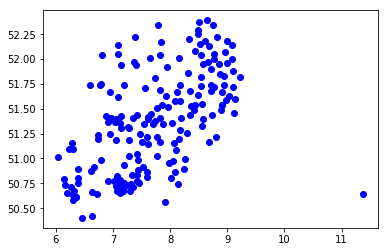

In [10]:
import numpy as np
import pandas
import csv

# load csv data via numpy.loadtxt
# fastest method but uncomfortable

filename = os.path.join('/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations', 'LUA-Stationen2_Bonn.csv')

# create datatype of data to be read
meta_type = np.dtype({'names': ['Station',  'Geogr.Laenge', 'Geogr.Breite'],
                'formats': ['|S32', np.float, np.float]})

# load data with some definitions
meta = np.loadtxt(filename, delimiter=',', usecols=[3,6,7], unpack=False, dtype=meta_type, skiprows=0,
                  converters={0: lambda s: float(s.strip() or 0)})
                  
#print(meta)
#print(meta.dtype)
fig, ax = pl.subplots()
for st, lon, lat in meta:
    ax.plot(lon, lat, marker='o', color='b', label=st)
pl.show()


Load radar metadata

In [1]:
# convective event
#f = create_filename('n_ppi_180deg', 12, 4, 2016, 11, 20)
#f = create_filename('ppi_1p5deg', 12, 4, 2013, 11, 20)
#lokal herkopiert
f='/home/silke/Python/projects/climatology/2016-04-12--11:20:00,00.mvol'
rdata, rmeta = wrl.io.read_gamic_hdf5(f)
#print(rmeta)
r = rmeta['SCAN0']['r']
r=np.arange(100,7100,100)
#print(r)
az = rmeta['SCAN0']['az']
el = rmeta['SCAN0']['el']
sitecoords = (rmeta['VOL']['Longitude'], rmeta['VOL']['Latitude'], 
              rmeta['VOL']['Height'])

proj_radar = wrl.georef.create_osr("aeqd", lat_0=sitecoords[1],
                               lon_0=sitecoords[0])
radius = wrl.georef.get_earth_radius(sitecoords[1], proj_radar)

proj_wgs = wrl.georef.get_default_projection()

coords = wrl.georef.spherical_to_centroids(r, az, el, sitecoords, proj=proj_wgs)
cent_lon = coords[..., 0]
cent_lat = coords[..., 1]
cent_alt = coords[..., 2]

NameError: name 'wrl' is not defined

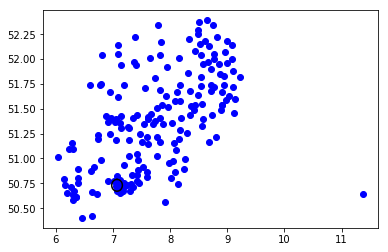

In [12]:
fig, ax = pl.subplots()
for st, lon, lat in meta:
    ax.plot(lon, lat, marker='o', color='b', label=st)
pl.plot(cent_lon[:,-1], cent_lat[:,-1], 'k')
#pl.show()

Get stations within radar domain

In [13]:
from matplotlib.path import Path

x = np.array([m[1] for m in meta])
y = np.array([m[2] for m in meta])
station = np.array([m[0] for m in meta])
points = np.squeeze(np.dstack((x,y)))
vertices = np.squeeze(np.dstack((cent_lon[:,-1], cent_lat[:,-1])))
pth = Path(vertices)

contains = pth.contains_points(points)
pts = points[contains==True]
stations = station[contains==True]

print(points.shape, pts.shape)
x, y = pts[:, 0], pts[:, 1]

((196, 2), (13, 2))


###Import and save station data, needs to be done only once

In [14]:
import datetime as dt
import glob
# load lanuv data
#fpath = '/automount/agh/Projects/regendaten/Read/.lanuv/'
fpath = '/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations'
meta_type = np.dtype({'names': ['Time',  'Rain'], 
                      'formats': [dt.datetime, np.float]})

rain = []
data = np.array([])
for i, st in enumerate(stations):
    filename = os.path.join(fpath, st[:12])
    print(st)
    filename = glob.glob(filename + '*')
    # create datatype of data to be read

    # load data with some definitions
    print(st, filename)
    try:
        data = np.loadtxt(filename[0], delimiter=' ', usecols=[0,1], unpack=False, dtype=meta_type, skiprows=0,
                          converters={0: lambda x: dt.datetime.strptime(x, "%Y%m%d%H%M%S")})#, 1: lambda s: s.strip() or ''})
        np.savez_compressed(st, data=data)
    except:
        pass

EschmarMuellekoven
('EschmarMuellekoven', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/EschmarMuelle.csv'])
Zeisigweg
('Zeisigweg', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Zeisigweg.csv'])
EndenichWiesenweg
('EndenichWiesenweg', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/EndenichWiesenweg.csv'])
Heizkraftwerk
('Heizkraftwerk', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Heizkraftwerk.csv'])
Ippendorf
('Ippendorf', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/Ippendorf.csv'])
KlaeranlageHersel
('KlaeranlageHersel', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/KlaeranlageHersel.csv'])
BadGodesbergKlaeranl
('BadGodesbergKlaeranl', ['/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations/BadGodesbergKlaeranl.csv', '/ho

Load station .npz data

In [14]:
def load_station(station):
    data = np.load(station.decode() + '.npz', encoding='bytes')
    print(data)
    return data['data']

(2103839,)


(0, 4)

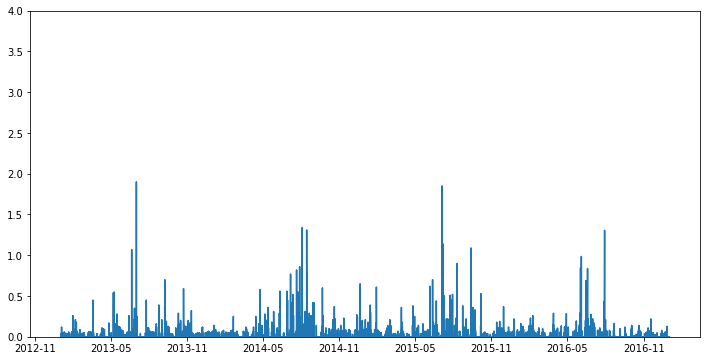

In [15]:
st0 = load_station(stations[5])
print(st0.shape)
fig = pl.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(st0['Time'], st0['Rain'])
ax.set_ylim(0,4)

In [16]:
print(stations[0])
print(stations[1])
print(stations[2])
print(stations[3])
print(stations[4])
print(stations[5])
print(stations.shape)

EschmarMuellekoven
Zeisigweg
EndenichWiesenweg
Heizkraftwerk
Ippendorf
KlaeranlageHersel
(13,)


Create array of datetime objects

#Load dates, the events collected in the folder

In [16]:
datepath="/home/silke/Python/output/Riming/"
#dates = sorted(glob.glob(datepath + "20*/"))
#print(dates[1][33:43])
#for l in range(len(dates)):
#    dates[l]=dates[l][33:43]
#print(dates)
###Versteh Fehler nicht, lasse erstmal 2013-05-29 weg
##Ich glaub 2015-04-02 gibts keine Wippeninfo, ebenfalls weg, fast das komplette 2015 faellt weg
##-> war nur bei Lanuv-Stationen so, hab nun Stadt Bonn Daten drin
##Ich glaub '2015-04-04'ist die ML zu niedrig
##, '2016-01-10' '2016-01-11', '2016-01-13'taugen auch nichts
## , '2016-01-02',  hab ich nun noch nicht bei Stadt Bonn Daten!!!
datesredu=['2013-04-12','2014-05-06','2014-05-27','2014-06-28','2014-07-08','2014-07-09','2014-10-07','2014-10-08','2014-11-04','2014-12-12',
       '2015-03-29','2015-04-02','2015-05-03',
       '2015-06-02', '2015-06-23', '2015-08-04','2015-08-17','2015-08-27','2015-09-01','2015-09-13', 
       '2015-09-16','2015-09-22','2015-10-05','2015-11-17', '2015-11-19', '2015-11-29', '2015-12-04', 
       '2015-12-08','2015-12-09',
       '2015-12-11', '2015-12-16', '2015-12-22', '2015-12-25','2016-01-07','2016-01-30','2016-09-04']
#erste Zeile, 2 Termine neu
#zweite Zeile bis 7 neu
dates=['2014-08-26','2016-09-04','2014-10-09','2014-07-05',
        '2015-06-22','2015-02-27','2015-01-08','2015-01-02','2014-12-19','2014-11-16','2014-10-15',
        '2013-04-12','2013-07-03','2014-05-06','2014-05-27','2014-06-28','2014-07-08','2014-07-09','2014-10-07','2014-10-08','2014-11-04','2014-12-12',
       '2015-03-29','2015-04-02','2015-05-03','2015-05-29',
       '2015-06-02', '2015-06-13','2015-06-23', '2015-07-13','2015-08-04','2015-08-08','2015-08-17',
       '2015-08-27','2015-09-01','2015-09-13', 
       '2015-09-16','2015-09-22','2015-10-05','2015-11-06','2015-11-17', '2015-11-19', '2015-11-20',
       '2015-11-29', '2015-12-08','2015-12-09',
       '2015-12-11', '2015-12-16', '2015-12-22', '2015-12-25','2016-01-02','2016-01-07']
print(dates)


['2014-08-26', '2016-09-04', '2014-10-09', '2014-07-05', '2015-06-22', '2015-02-27', '2015-01-08', '2015-01-02', '2014-12-19', '2014-11-16', '2014-10-15', '2013-04-12', '2013-07-03', '2014-05-06', '2014-05-27', '2014-06-28', '2014-07-08', '2014-07-09', '2014-10-07', '2014-10-08', '2014-11-04', '2014-12-12', '2015-03-29', '2015-04-02', '2015-05-03', '2015-05-29', '2015-06-02', '2015-06-13', '2015-06-23', '2015-07-13', '2015-08-04', '2015-08-08', '2015-08-17', '2015-08-27', '2015-09-01', '2015-09-13', '2015-09-16', '2015-09-22', '2015-10-05', '2015-11-06', '2015-11-17', '2015-11-19', '2015-11-20', '2015-11-29', '2015-12-08', '2015-12-09', '2015-12-11', '2015-12-16', '2015-12-22', '2015-12-25', '2016-01-02', '2016-01-07']


# Loop over all events

In [19]:
print(YD.shape)
print(zhmax.shape)

NameError: name 'YD' is not defined

In [19]:

YD = np.array(Y1)
print(YD.shape)

fig, ax = pl.subplots()

ax.plot(YD[1], 'xr')
print(YD[1,:])


NameError: name 'Y1' is not defined

Load dates, the events collected in the folder

##Check Delta Estimation

('05:00', 8.0, 1.0)
('05:00', 0.3467476515378803, 0.13040223157592118)
('05:00', 0.3467476515378803, 0.6559029922951013)


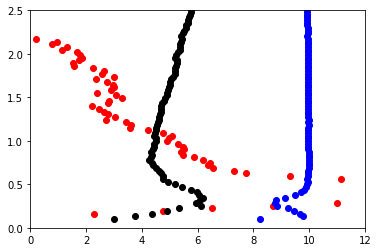

In [53]:
fig = pl.figure()
#timei=17
timei=30
print(time[timei],topi[timei],bottomi[timei])
print(time[timei],bh[int(topi[timei])],bh[int(bottomi[timei])])
print(time[timei],bh[int(topi[timei])],bh[int(topi[timei]+10)])
ind=np.arange(0,550,1)
#heightkm=bh[int(ind)]
pl.plot(zh[:,timei]-20,bh, 'ro')
pl.plot(10*rhohv[:,timei],bh, 'bo')
#pl.plot(2*zdr[:,timei],bh, 'bo')
pl.plot(phi[:,timei],bh, 'ko')
#pl.ylim((50,110))
pl.ylim((0,2.5))
pl.xlim((0,12))
pl.show()
#fig.savefig('/home/silke/Python/projects/climatology/testkdp/Time_13:55.png')
fig.savefig('/home/silke/Python/projects/climatology/testkdp/02042015_Time_04:30.png')


Snowrate

In [ ]:
# Multilinear fitting from Ryzhkov S=1.48*kdpdlg**0.61 * Zhdgl**0.33

Read temperature information

In [24]:
path="/home/silke/Python/projects/climatology/"
in_file_temp= open(path + "temp-" + date + ".dat","r")
ht8, ht10, ht15 =np.loadtxt(in_file_temp, skiprows=1, usecols = (1,2,3), dtype = 'f4')
print(ht8, ht10, ht15)

#hardcoding, mach jetzt fuer ht15 einfach ein ht20 und das ist 1.5km höher
ht15=ht10+1500

#90percentile of KDP, ZDR, Z between -10 and -15
#print(bh)

#ZDR in der DGL
zdrdgl=np.zeros(times)
#ZDR in der DGL
kdpdgl=np.zeros(times)

for i in range(len(bh)):
    if(bh[i]<ht10/1000.):
        ht10i=i
    if(bh[i]<ht15/1000.):
        ht15i=i
print(ht10i)
print(bh[ht10i], bh[ht15i])
# Determine 90percentile in the DGL
#Index des 90sten


#evtl erst mit np.nanargmax die Laenge der sortierten Geschichte bestimmen
for i in range(times):
    index=(int(len(zdr[ht10i:ht15i,i])*0.9))
    zdrs=np.sort(zdr[ht10i:ht15i,i]) 
    zdrdgl[i]=zdrs[index]
    print(zdrdgl[i])
    
for i in range(times):
    index=(int(len(kdp[ht10i:ht15i,i])*0.9))
    kdps=np.sort(kdp[ht10i:ht15i,i]) 
    kdpdgl[i]=kdps[index]
    print(kdpdgl[i])
    

NameError: name 'date' is not defined

In [17]:
# Retrievals a la Ryzhkov et al. (2018): Small different compared to routines in QVPs
def RetrievalsIce(result_data_zh,result_data_zdr,result_data_kdp):
    """
    Compute the retrievals based on z, zdr, kdp
    """
    zv=result_data_zh - result_data_zdr
    zhlin= wrl.trafo.idecibel(result_data_zh)
    zvlin = wrl.trafo.idecibel(zv)
    zdrlin = wrl.trafo.idecibel(result_data_zdr)
    zdp=zhlin-zvlin
    ##ratio corresponds to eta in Rythkovs ext. abstract
    ratio=(zdp/result_data_kdp/32.)**(1/2.)
    ratio_mask = np.where(ratio <= .15)
    kdp_mask = np.where(result_data_kdp < 0.01)
    ratio[ratio_mask] = np.nan
    result_data_dm = -0.1 + 2.0*ratio 
    result_data_dm[kdp_mask] = np.nan
    kdp2=np.copy(result_data_kdp)
    kdp2[kdp_mask]=np.nan
    gamma=0.78*ratio**2.
    result_data_logNt= 0.1* result_data_zh - 2. * np.log10(gamma) -1.33
    result_data_logNt[kdp_mask] = np.nan
    #print(result_data_logNt)
    result_data_IWC = 4.0*10**(-3) * kdp2*32./(1-zdrlin**(-1))
    result_data_IWC[kdp_mask] = np.nan  
    #### another IWC-retrieval IWC=0.67 KDP**0.65 x Zlin**0.28
    result_data_IWC2=0.67* kdp2**0.65 * zhlin**0.28
    return result_data_logNt, result_data_dm, result_data_IWC, result_data_IWC2
 

In [18]:
# read the QVP data
for k in range(len(dates)):
#for k in range(23,24):    
    date=dates[k]
    print(date)
    #date="2013-04-12"

    zh=[]
    zv=[]
    kdp=[]
    rhohv=[]
    phi=[]
    kdp=[]

    # hier mit readlines und append
    # noch automatisieren für die verschiedenen Daten/Subfolder
    path="/home/silke/Python/output/Riming/" + date +"/textfiles/"
    in_file_zh= open(path + "zh_output_Bonn_18.0_" + date + ".txt","r")

    timeline=in_file_zh.readlines()
    in_file_zh.close()
    time=timeline[4].split()
    #Enthaelt die verschiedenen Zeitpunkte
    time=time[3:]
    dates0 = dt.datetime.strptime(dates[k]+time[0], '%Y-%m-%d%H:%M')
    dates1 = dt.datetime.strptime(dates[k]+time[-1], '%Y-%m-%d%H:%M')
    print(dates0, dates1)
    #print(time)
    #Groesse des Feldes und damit Anzahl der data-Columns, die wir wollen
    times=len(time)+2
    #print(times)
    in_file_zh= open(path + "zh_output_Bonn_18.0_" + date + ".txt","r")
    #zh =np.loadtxt(in_file_zh, skiprows=4, dtype = 'f4').transpose()
    zh =np.loadtxt(in_file_zh, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_zdr= open(path + "zdr_output_Bonn_18.0_" + date + ".txt","r")
    zdr =np.loadtxt(in_file_zdr, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_rhohv= open(path + "rho_output_Bonn_18.0_" + date + ".txt","r")
    rhohv =np.loadtxt(in_file_rhohv, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_kdp= open(path + "kdp_output_Bonn_18.0_" + date + ".txt","r")
    kdp =np.loadtxt(in_file_kdp, skiprows=4, usecols = range(2,times,1), dtype = 'f4')

    path="/home/silke/Python/output/Riming/" + date + "/textfiles/"
    in_file_phi= open(path + "phi_output_Bonn_18.0_" + date + ".txt","r")
    phi =np.loadtxt(in_file_phi, skiprows=4, usecols = range(2,times,1),dtype = 'f4')


    #hier mit loadtxt, muß dtype hier so angegeben werden?
    #zh, zv, kdp, rhv, dlt, ah, ade =np.loadtxt(in_file, skiprows=2, usecols= (1,2,3,4,5,6,7), dtype = 'f4').transpose()
    print "das ist zh, benutzt loadtxt with comma\n", type(zh), type(zh[0])
    print "--------------------------------------------------------------------"

    # Create datetime arrays
    import datetime as dt
    from datetime import timedelta
    start = dates0
    end = dates1
    #start = dt.datetime(2013,4,12,0,1)
    #tarr = np.array([start + timedelta(minutes=i*5) for i in range(288)])
    tarr = np.arange(start, end + timedelta(minutes=5), timedelta(minutes=5))
    t5min=np.arange(start - timedelta(minutes=2), end + timedelta(minutes=7), timedelta(minutes=5))
    #thour=np.arange(start - timedelta(minutes=29), end + timedelta(minutes=50), timedelta(hours=1))
    #print(tarr)

    # Load and process station data

    #print(zh)
    #zhi = np.squeeze(wrl.trafo.idecibel(zh))
    good = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 19, 
            20, 22, 23, 24, 26, 29, 31, 32, 33, 34, 35, 36, 37, 38, 
            39, 40, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 58, 
            60, 61, 62, 63, 64, 66, 67, 68, 70, 71, 75, 77, 78, 79, 
            80, 83, 85, 86, 87, 88]
    # other good stations: 18, 21, 25, 28, 55, 57
    X1 = []
    Y1 = []
    for st, name in enumerate(stations):#good:
        
        try:
            st0 = load_station(stations[st])
        except:
            continue
        #st0 = load_station(st)
        t_MEZ = st0['Time']
        #ACHTUNG die Stationsdaten sind in MEZ angegeben, Radar in UTC, also -1h
        t = t_MEZ - timedelta(hours=1)
        rr = st0['Rain']
        #Zeiten von QVP
        #mit dem idx hat die 5minutenGeschichte funktioniert
        idx = (t>=dates0-timedelta(minutes=10)) & (t<=dates1+timedelta(minutes=10))  
        #brauch fuer die Stunden nun aber ein groesseres Fenster
        #idx = (t>=dates0-timedelta(minutes=40)) & (t<=dates1+timedelta(minutes=40))  
        #idx = (t>=dt.datetime(2013,4,12,1,0)) & (t<dt.datetime(2013,4,13,0,59))
        #idx = (t>=dt.datetime(2011,4,3,1,0)) & (t<dt.datetime(2011,4,4,0,59))
        #t1 = t[idx] - timedelta(hours=1)
        t1 = t[idx]
        #print('t1',t1)
        #print(len(np.nonzero(idx)[0]))
        if (len(np.nonzero(idx)[0]) > 10):
            
            #print(t1[0:15])
            off = (t1[0].minute % 5) - 1
            t2 = np.array(wrl.util.from_to(t1[0] - timedelta(minutes=off), t1[-1], 60))
            #print('t2',t2)
            rra = rr[idx] # in mm
            #print('t5',t5min), hat funktioniert       
            rr1 = aggregate_in_time(rra, t1, t5min, func='nansum')  
            #will nun aber Stundenmittel
            #rr1 = wrl.util.aggregate_in_time(rra, t1, thour, func='nansum') 

            # musste um die 5minuten Mittel in mm/h angeben mal 12 nehmen
            Y=rr1*12
            #nun sind es dann aber schon mm/h, hab von einem Stundenintervall aufsummiert
            #Y=rr1
            mask = np.isnan(Y)
            #print(mask)
            Y[mask] = 0.0
            #mask = ~np.isnan(X) & np.isfinite(Y)
            #X1.append(X[mask])
            Y1.append(Y)
            #Y1.append(Y)
    YD = np.array(Y1)
    print('YD',YD.shape)
    ###
    St2h=np.zeros(YD.shape[1])
    St2m=np.zeros(YD.shape[1])
    s1=np.copy(YD[0,:])
    s2=np.copy(YD[1,:])
    St2m=(s1+s2)/2.
    St_shorter=runningMean(St2m,12)
    anz=len(St_shorter)+5
    St2h[0:5]=np.nan    
    St2h[5:anz]=St_shorter
    St2h[-6:]=np.nan
    stellen=np.isnan(St2h)
    St2h[stellen]=St2m[stellen]

    
    #Bestimmung der ML-Height
    elevation = 18.0
    dr = 100.0
    bins = zh.shape[0]
    times = zh.shape[1]
    #Kdp in der ML
    kdpml=np.zeros(times)
    kdprain=np.zeros(times)
    kdpsnow=np.zeros(times)
    kdpsnow2=np.zeros(times)
    kdp2km=np.zeros(times)
    kdpslp=np.zeros(times)
    kdpslp2=np.zeros(times)
    #Differenz von PHI oberh und unterh der ML, +/-10 Indexhoehen
    diffml=np.zeros(times)
    #maximales phi, z, zdr in der ML
    phimax=np.zeros(times)
    zhmax=np.zeros(times)
    zhrain=np.zeros(times)
    zdrrain=np.zeros(times)
    rhohvrain=np.zeros(times)
    zhsnow=np.zeros(times)
    beta=np.zeros(times)
    zdrsnow=np.zeros(times)
    rhohvsnow=np.zeros(times)
    zdrmax=np.zeros(times)
    #dazugehoeriger Index
    phimaxi=np.zeros(times)
    zhmaxi=np.zeros(times)
    zdrmaxi=np.zeros(times)
    #minimales rhohv
    rhohvmin=np.zeros(times)
    #dazugehoeriger Index
    rhohvmini=np.zeros(times)
    #ML bottom defined with RHOhv
    Rmlb=np.zeros(times)
    #ML bottom defined with RHOhv
    Rmlt=np.zeros(times)
    #delta in ML
    deltaml=np.zeros(times)


    #bh=beam_height
    toph, bottomh, topi, bottomi, bh, cth = melting_layer_qvp(zh,zdr,rhohv,elevation,dr,bins,height_limit=10.)
    
    mlthick = toph - bottomh
    #print('ML-Detectionoutput', topi, bottomi)
    ####temperature information
    #path="/home/silke/Python/projects/climatology/"
    #in_file_temp= open(path + "temp-" + date + ".dat","r")
    #ht8, ht10, ht15 =np.loadtxt(in_file_temp, skiprows=1, usecols = (1,2,3), dtype = 'f4')
    #print(ht8, ht10, ht15)
    ###
    # http://weather.uwyo.edu/upperair/sounding.html
    filename = os.path.join('/home/silke/Python/radarlecture2016/radarmeteorology/common/radarmet_data/stations', 
                            'radio_'+dates[k]+'.txt')
    radio = np.genfromtxt(filename, skip_header=3, autostrip=True, 
                         invalid_raise=False)
    stemp = radio[:, 2]
    sheight = radio[:, 1]
    # remove nans
    idx = np.isfinite(stemp)
    stemp = stemp[idx]
    sheight = sheight[idx]
    # highres height
    ht = np.arange(0., 20000.)
    ipolfunc = interpolate.interp1d(sheight, stemp, kind='linear', 
                                    bounds_error=False)
    itemp = ipolfunc(ht)
    ## ctt aus cth,geht so?
    ctt = ipolfunc(cth*1000.)
    #highres temp
    mask0 = (itemp <= -19.99) & (itemp >= -20.01)
    mask1 = (itemp <= -14.99) & (itemp >= -15.01)
    mask2 = (itemp <= -9.99) & (itemp >= -10.01)
    mask3 = (itemp <= -7.99) & (itemp >= -8.01)
    
    h=ht[mask0]
    ht20=h[0]
    h=ht[mask1]
    ht15=h[0]
    h=ht[mask2]
    ht10=h[0]
    h=ht[mask3]
    ht8=h[0]
    print("ht20, ht15, ht10, ht8")
    print(ht20, ht15, ht10, ht8)

    #90percentile of KDP, ZDR, Z between -10 and -15
    #print(bh)

    #ZDR in der DGL
    zdrdgl=np.zeros(times)
    #ZDR in der DGL
    kdpdgl=np.zeros(times)
    #Zh in der DGL
    zhdgl=np.zeros(times)
    #Retrievals in DGL
    logNtdgl=np.zeros(times)
    dmdgl=np.zeros(times)
    IWCdgl=np.zeros(times)
    IWCdgl2=np.zeros(times)
    


    for i in range(len(bh)):
        #nur zwischen -10 und -15 schauen, oder schon ab -8
        #jetzt schau ich zwischen -10 und -20
        if(bh[i]<ht10/1000.):
            ht10i=i
        if(bh[i]<ht20/1000.):
            ht20i=i
    print(ht10i)
    print(bh[ht10i], bh[ht20i])
    # Determine 90percentile in the DGL
    #Index des 90sten
    # Add the RHOhv- definition of ML_bottom and ML_top: using threshold of 0.97
    ##accordings heights are refered as Rmlb and Rmlt
    
    path2="/home/silke/Python/projects/climatology/"
    f = open(path2 + 'out_'+ date +'.txt', 'wb')
    f2 = open(path2 + 'FZout_'+ date +'.txt', 'wb')
    f3 = open(path2 + 'Kdpout_'+ date +'.txt', 'wb')
    f4 = open(path2 + 'Erika_'+ date +'.txt', 'wb')
    ###und hier kommen die Iceretrievals rein
    f5 = open(path2 + 'Retriev_'+ date +'.txt', 'wb')

#    print("%5s %4s %4s %5s %5s %5s %3s %2s %3s %4s %4s %4s %4s %4s %6s %5s %5s %5s %4s %5s %5s %5s %5s %5s" %
#              ('Time','ML_b','ML_t','ML_th','Kdp_ML','Phimax','D_ML','Dh', 
#               'Zh_ML','Zhh','Zdr_ML','Zdrh',
#               'R_ML','Rh','Kdp_D','Zdr_D', 'Zh_D', 'Zh_S', 'Zdr_S','St1', 'St2', 'St3', 'St4', 'St5'))
    f.write("%5s %4s %4s %5s %5s %5s %3s %2s %3s %4s %4s %4s %4s %4s %6s %5s %5s %5s %4s %5s %5s %5s %5s %5s %5s %5s %5s  %5s %5s" %
              ('Time','ML_b','ML_t','ML_th','Kdp_ML','Phimax','D_ML','Dh', 
               'Zh_ML','Zhh','Zdr_ML','Zdrh',
               'R_ML','Rh','Kdp_D','Zdr_D', 'Zh_D', 'Zh_rain','Zh_S', 'Zdr_S','Rhv_S','St1', 'St2', 'St3', 'St4', 'St5', 'St2h', 'Rmlb', 'Rmlt\n')) 
    
    f2.write("%5s %4s %4s %5s %5s %5s %3s %2s %3s %4s %4s %4s %4s" %
              ('Time','ML_b','ML_t','ML_th','Zh_ML','Zh_rain','Zh_snow','Zdr_ML', 
               'Zdr_rain','Zdr_snow','R_ML','R_rain','R_snow\n'))  
    
    f3.write("%5s %4s %4s %5s %5s %5s %4s %3s %4s %3s %3s %4s" %
              ('Time','ML_b','ML_t','ML_th','Kdp_ML','Kdp_snow','Kdp_snow2', 'Kdp_dgl', 'Kdp2km','Kdp_slp','Kdp_slp2','beta\n')) 
    
    #new
    f4.write("%5s %5s %5s %5s %5s" %
              ('Time','Kdp_dgl', 'Zdr_dgl','Zh_dgl','Ctt\n')) 
    
    f5.write("%5s %5s %5s %5s %5s" %
          ('Time','LogNt_dgl', 'Dm_dgl','IWC_dgl', 'IWC_dgl2\n')) 

    
    print('timeslaenge',times)
    for i in range(times):
        if(topi[i]>=999 or topi[i]==np.nan):
            print('hello')
            topi[i]=np.nan
            bottomi[i]=np.nan
            toph[i]=np.nan
            bottomh[i]=np.nan
            diffml[i]=np.nan
            dh=np.nan
            kdpml[i]=np.nan
            phimax[i]=np.nan
            deltaml[i]=np.nan
            zhmax[i]=np.nan
            zhrain[i]=np.nan
            zdrrain[i]=np.nan
            rhohvrain[i]=np.nan
            kdprain[i]=np.nan
            kdpsnow[i]=np.nan
            kdpsnow2[i]=np.nan
            kdp2km[i]=np.nan
            kdpslp[i]=np.nan
            kdpslp2[i]=np.nan
            zhsnow[i]=np.nan
            zdrsnow[i]=np.nan
            rhohvsnow[i]=np.nan
            zdrmax[i]=np.nan
            rhohvmin[i]=np.nan
            zhmaxi[i]=np.nan
            zdrmaxi[i]=np.nan
            rhohvmini[i]=np.nan
            Rmlt[i]=np.nan
            Rmlb[i]=np.nan
        else:
        #print(topi[i],bottomi[i])
            print('index',topi[i],i)
            if(bh[int(bottomi[i])]>=0.4):
                index=int(topi[i]+10)+np.argmin(phi[int(topi[i]+10):int(topi[i])+20,i])
                indexs=index
                diffml[i]=phi[index,i]-phi[int(bottomi[i]-10),i]
                dh=bh[int(index)]-bh[int(bottomi[i])-10]
                slantrange=dh/np.sin(2*np.pi*elevation/360.)
                kdpml[i]=diffml[i]/slantrange/2.
                print('t,dh,slantrange, diffml[i], kdp, hohe ML', i, dh, slantrange, diffml[i], kdpml[i])
                kdpsnow[i]=kdp[indexs+5,i]
                if (zh[indexs+5,i]<=5):
                    kdpsnow[i]=np.nan
                kdpsnow2[i]=kdp[indexs+10,i]
                if (zh[indexs+10,i]<=5):
                    kdpsnow2[i]=np.nan
                
                #print(kdpml[i],diffml[i],mlthick[i])

                # Determine delta in the ML
                j=int(bottomi[i]-10)
                phimaxi[i]=j
                phimax[i]=phi[int(bottomi[i])-10,i]
                while j<int(index):
                    j = j+1
                    if phi[j,i]>phimax[i]:
                        phimax[i]=phi[j,i]
                        phimaxi[i]=j

                #print(phi[int(topi[i])+10,i], phi[int(bottomi[i])-10,i],phimax[i])
                deltaml[i]=phimax[i]-(phi[int(bottomi[i])-10,i]
                                      +2.*kdpml[i]*(bh[int(phimaxi[i])]-bh[int(bottomi[i])-10])/np.sin(2*np.pi*elevation/360.))
                #kdpsnow[i] = (phi[int(phimaxi[i]+10),i]-phi[int(phimaxi[i]),i]+deltaml[i])/(bh[int(phimaxi[i]+10)]-bh[int(phimaxi[i])])/2.
                #kdprain[i] = (phi[int(phimaxi[i]),i]-phi[int(phimaxi[i]-10),i]-deltaml[i])/(bh[int(phimaxi[i])]-bh[int(phimaxi[i]-10)])/2.
                
            else:
                #glaube ich kann da nicht unterscheiden, muss 10 Schritte runter
                index=int(topi[i]+10)+np.argmin(phi[int(topi[i]+10):int(topi[i])+20,i])
                indexs=index
                diffml[i]=phi[int(index),i]-phi[1,i]
                dh=bh[int(index)]-bh[1]
                slantrange=dh/np.sin(2*np.pi*elevation/360.)
                kdpml[i]=diffml[i]/slantrange/2.
                print('t,dh,slantrange,diffml[i], kdp, tiefe ML', i, dh,slantrange, diffml[i],kdpml[i])
                kdpsnow[i]=kdp[indexs+5,i]
                if (zh[indexs+5,i]<=5):
                    kdpsnow[i]=np.nan
                kdpsnow2[i]=kdp[indexs+10,i]
                if (zh[indexs+10,i]<=5):
                    kdpsnow2[i]=np.nan
                #kdpsnow[i]=kdp[index,i]
                
                #kdprain[i]=kdp[int(bottomi[i]-10),i]
                #print(kdpml[i],diffml[i],mlthick[i])

                # Determine delta in the ML
                j=1
                phimax[i]=phi[j,i]
                phimaxi[i]=j
                while j<int(index):
                    j = j+1
                    if phi[j,i]>phimax[i]:
                        phimax[i]=phi[j,i]
                        phimaxi[i]=j

                #print(phi[int(topi[i])+10,i], phi[int(bottomi[i])-10,i],phimax[i])
                deltaml[i]=phimax[i]-(phi[1,i]+2.*kdpml[i]*(bh[int(phimaxi[i])]-bh[1])/np.sin(2*np.pi*elevation/360.))
                #kdpsnow[i] = (phi[int(phimaxi[i]+10),i]-phi[int(phimaxi[i]),i]+deltaml[i])/(bh[int(phimaxi[i]+10)]-bh[int(phimaxi[i])])/2.
                #kdprain[i] = (phi[int(phimaxi[i]),i]-phi[1,i]-deltaml[i])/(bh[int(phimaxi[i])]-bh[1])/2.
            #Determine other variables in the ML
            ##hilfe
            ##hilfe ende
            if(bh[int(bottomi[i])]>=0.4):                
                j=int(bottomi[i])
                zdrmaxi[i]=j
                zhmaxi[i]=j
                rhohvmini[i]=j
                zhmax[i]=zh[int(bottomi[i]),i]
                zdrmax[i]=zdr[int(bottomi[i]),i]
                rhohvmin[i]=rhohv[int(bottomi[i]),i]
                #habec ca 30 m Auflösung, -5 entsp. ca. 150m Differenz
                drunter=int(bottomi[i])-5
                #drueber=int(topi[i])+1
                drueber=indexs+1
                zhrain[i]=zh[drunter,i]
                zdrrain[i]=zdr[drunter,i]
                rhohvrain[i]=rhohv[drunter,i]
                zhsnow[i]=zh[drueber,i]
                
                beta[i]=(zh[drueber+66,i]-zhsnow[i])/(bh[int(drueber+66)]-bh[drueber])
                if (zhsnow[i]<=5):
                    beta[i]=np.nan
                if (zh[drueber+66,i]<=5):
                    beta[i]=np.nan
                
                kdp2km[i]=kdp[drueber+66,i]
                if (zh[drueber+66,i]<=5):
                    kdp2km[i]=np.nan
                zdrsnow[i]=zdr[drueber,i]
                rhohvsnow[i]=rhohv[drueber,i]
                while j<int(index):
                    j = j+1
                    if zh[j,i]>zhmax[i]:
                        zhmax[i]=zh[j,i]
                        zhmaxi[i]=j
                    if zdr[j,i]>zdrmax[i]:
                        zdrmax[i]=zdr[j,i]
                        zdrmaxi[i]=j
                    if rhohv[j,i]<rhohvmin[i]:
                        rhohvmin[i]=rhohv[j,i]
                        rhohvmini[i]=j
            else:
                j=int(bottomi[i])
                zdrmaxi[i]=j
                zhmaxi[i]=j
                rhohvmini[i]=j
                zhmax[i]=zh[j,i]
                zdrmax[i]=zdr[j,i]
                rhohvmin[i]=rhohv[j,i]
                zdrrain[i]=zdr[7,i]
                rhohvrain[i]=rhohv[7,i]
                zhrain[i]=zh[7,i]
                
                drueber=indexs+1
                
                beta[i]=(zh[drueber+66,i]-zhsnow[i])/(bh[int(drueber+66)]-bh[drueber])
                if (zhsnow[i]<=5):
                    beta[i]=np.nan
                if (zh[drueber+66,i]<=5):
                    beta[i]=np.nan
                
                kdp2km[i]=kdp[drueber+66,i]
                if (zh[drueber+66,i]<=5):
                    kdp2km[i]=np.nan
                    
                    
                zdrsnow[i]=zdr[drueber,i]
                rhohvsnow[i]=rhohv[drueber,i]
                zhsnow[i]=zh[drueber,i]
                while j<int(index):
                    j = j+1
                    if zh[j,i]>zhmax[i]:
                        zhmax[i]=zh[j,i]
                        zhmaxi[i]=j
                    if zdr[j,i]>zdrmax[i]:
                        zdrmax[i]=zdr[j,i]
                        zdrmaxi[i]=j
                    if rhohv[j,i]<rhohvmin[i]:
                        rhohvmin[i]=rhohv[j,i]
                        rhohvmini[i]=j
                        #FEHLER indexs+10!!
            kdpslp2[i]=(kdp2km[i]-kdpsnow2[i])/(bh[int(drueber+66)]-bh[int(indexs+10)])
            if (zh[int(indexs+10),i]<=5):
                    kdpslp2[i]=np.nan
                    
            kdpslp[i]=(kdp2km[i]-kdpsnow[i])/(bh[int(drueber+66)]-bh[int(indexs+5)])
            if (zh[int(indexs+5),i]<=5):
                    kdpslp[i]=np.nan
            
            #Variables in DGL, alternative Perzentilbestimmung, hier Probleme mit nan        
            #index2=(int(len(zdr[ht10i:ht20i,i])*0.90))
            #zdrs=np.sort(zdr[ht10i:ht20i,i]) 
            #zdrdgl[i]=zdrs[index2]
            #will nur die wo auch Wolke ist, sonst habe ich negative Werte, die mir das Perzentil versauen
            zdrs=zdr[ht10i:ht20i,i]
            kdps=kdp[ht10i:ht20i,i] 
            zhs=zh[ht10i:ht20i,i]
            
            missing= zhs < -10.
            zhs=zhs[~missing]
            zdrs=zdrs[~missing]
            kdps=kdps[~missing]
            ###Insert corresponding values of Nt, Dm, IWC
            logNt, dm, IWC, IWC2 = RetrievalsIce(zhs,zdrs,kdps)
            logNtdgl[i]= np.nanpercentile(logNt, 90)
            dmdgl[i]= np.nanpercentile(dm, 90)
            IWCdgl[i]= np.nanpercentile(IWC, 90)
            IWCdgl2[i]= np.nanpercentile(IWC2, 90)
            ###
            zdrdgl[i]=np.nanpercentile(zdrs, 90)
            #print(zdrdgl[i])

            #index2=(int(len(kdp[ht10i:ht20i,i])*0.90))
            #kdps=np.sort(kdp[ht10i:ht20i,i]) 
            #kdpdgl[i]=kdps[index2]
            kdpdgl[i]=np.nanpercentile(kdps, 90)
            #print(kdpdgl[i])

            #index2=(int(len(zh[ht10i:ht20i,i])*0.90))
            #zhs=np.sort(zh[ht10i:ht20i,i]) 
            #zhdgl[i]=zhs[index2]
            zhdgl[i]=np.nanpercentile(zhs, 90)
            #if (zhdgl[i]<=5):
            #    kdpdgl[i]=np.nan
            #print(kdpdgl[i])
            print('shapes',zh.shape, YD.shape)
    
# Einschub zur RHOhv-basierten Bestimmung von Rmlb und Rmlt        
        if np.isfinite(rhohvmini[i]):
            startj=int(rhohvmini[i])
            if rhohvmin[i]<=0.97:
                mltj=startj
                mlbj=startj
                while rhohv[mltj,i]<=0.97 and mltj<200:
                    mltj = mltj+1
                while rhohv[mlbj,i]<=0.97 and mlbj>1:
                    mlbj = mlbj-1
                Rmlb[i]=mlbj    
                Rmlt[i]=mltj
            else:
                Rmlb[i]=np.nan
                Rmlt[i]=np.nan
######################       
        
        try:
            print('zh.shape',zh.shape)
            
            f.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %4.1f %5.3f %5.2f %5.3f %4.2f %5.3f %6.3f %5.3f %5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" %
              (time[i], bottomh[i],toph[i],mlthick[i],kdpml[i],phimax[i], deltaml[i], bh[int(phimaxi[i])], 
               zhmax[i], bh[int(zhmaxi[i])], zdrmax[i], bh[int(zdrmaxi[i])],
               rhohvmin[i],bh[int(rhohvmini[i])], kdpdgl[i], zdrdgl[i], zhdgl[i], zhrain[i], zh[7,i], zdr[7,i], rhohv[7,i], YD[0,i], YD[1,i], YD[2,i], YD[3,i], YD[4,i], St2h[i], bh[int(Rmlb[i])], bh[int(Rmlt[i])]))
            
            f2.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %4.1f %5.3f %5.2f %5.3f %4.2f %5.3f %6.3f\n" %
              (time[i], bottomh[i],toph[i],mlthick[i], zhmax[i], zhrain[i],zhsnow[i],zdrmax[i],zdrrain[i],zdrsnow[i],rhohvmin[i],rhohvrain[i], rhohvsnow[i]))

            f3.write("%5s %4.2f %4.2f %5.2f %6.3f %6.3f %6.3f %6.3f %6.3f %6.3f %6.3f %5.2f\n" %
              (time[i], bottomh[i],toph[i],mlthick[i],kdpml[i],kdpsnow[i],kdpsnow2[i],kdpdgl[i],kdp2km[i],kdpslp[i], kdpslp2[i], beta[i])) 
            
            f4.write("%5s %4.2f %4.2f %5.2f %6.3f\n" %
              (time[i], kdpdgl[i], zdrdgl[i], zhdgl[i],ctt[i])) 
            
            f5.write("%5s %6.3f %6.3f %6.3f %6.3f\n" %
              (time[i],logNtdgl[i], dmdgl[i], IWCdgl[i], IWCdgl2[i])) 

        #except ValueError: 
        except ValueError:
            
            f.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %5.2f %4.2f %5.2f %4.2f %4.2f %5.2f %6.3f %4.2f %5.3f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" %
              (time[i], np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, 
               np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,
               np.nan,np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, YD[0,i], YD[1,i], YD[2,i], YD[3,i], YD[4,i], St2h[i], np.nan, np.nan))
            
            f2.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %4.1f %5.3f %5.2f %5.3f %4.2f %5.3f %6.3f\n" %
              (time[i], np.nan,np.nan,np.nan,np.nan,np.nan, np.nan, np.nan, 
               np.nan, np.nan, np.nan, np.nan, np.nan))
            f3.write("%5s %4.2f %4.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f %5.2f\n" %
              (time[i], np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan, np.nan,np.nan, np.nan)) 
            f4.write("%5s %4.2f %4.2f %5.2f %6.3f\n" %
              (time[i], np.nan,np.nan,np.nan,np.nan)) 
            f5.write("%5s %6.3f %6.3f %6.3f %6.3f\n" %
              (time[i],np.nan, np.nan, np.nan, np.nan)) 
            
    f.close()  
    f2.close()
    f3.close()
    f4.close()
    f5.close()

2014-08-26
(datetime.datetime(2014, 8, 26, 12, 30), datetime.datetime(2014, 8, 26, 18, 35))
das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 74))
ht20, ht15, ht10, ht8
(6118.0, 5225.0, 4497.0, 4192.0)
141
(4.467213689533994, 6.1144432111606)
('timeslaenge', 74)
('index', 82.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.9606074174884709, 3.1085909026832126, 0.8324775695800781, 0.1338995055382676)
('shapes', (550, 74), (12, 74))
('zh.shape', (550, 74))
('index', 82.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8986327470783144, 2.908036656352801, 1.0424699783325195, 0.1792394838034751)
('shapes', (550, 74), (12, 74))
('zh.shape', (550, 74))
('index', 81.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9296360324863344, 3.008365395458981, 0.5108728408813477, 0.08490870850537169)
('shapes', (550, 74), (12, 74))
('zh.shape', (550, 74))
('index', 81.

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (9, 21))
ht20, ht15, ht10, ht8
(7020.0, 6162.0, 5348.0, 5001.0)
169
(5.337076338807121, 7.017020336965099)
('timeslaenge', 21)
('index', 92.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.898971934314817, 2.909134289307224, 1.6766893863677979, 0.2881766910057428)
('shapes', (550, 21), (9, 21))
('zh.shape', (550, 21))
('index', 92.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.929986913913861, 3.0095008716104994, 2.0005412101745605, 0.3323709305164604)
('shapes', (550, 21), (9, 21))
('zh.shape', (550, 21))
('index', 97.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8680473271757361, 2.8090601584276826, 1.4791810512542725, 0.2632875353018811)
('shapes', (550, 21), (9, 21))
('zh.shape', (550, 21))
('index', 97.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8680473271757361, 2.8090601584276826, 0.

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 28))
ht20, ht15, ht10, ht8
(6848.0, 6105.0, 5228.0, 4846.0)
165
(5.212759248880669, 6.830206976143644)
('timeslaenge', 28)
('index', 104.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 1.116405296841636, 3.612763431020366, 1.7283754348754883, 0.2392040702188099)
('shapes', (550, 28), (11, 28))
('zh.shape', (550, 28))
('index', 102.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 1.0233539844620974, 3.311643058764611, 1.8674554824829102, 0.28195301385825583)
('shapes', (550, 28), (11, 28))
('zh.shape', (550, 28))
('index', 102.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9612995767798274, 3.1108307772013, 1.4969100952148438, 0.24059651624019848)
('shapes', (550, 28), (11, 28))
('zh.shape', (550, 28))
('index', 101.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9302420738916841, 3.0103265866438

('shapes', (550, 145), (11, 145))
('zh.shape', (550, 145))
('index', 54.0, 101)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 101, 1.021704706510529, 3.3063058831995438, 1.6756887435913086, 0.2534080031896094)
('shapes', (550, 145), (11, 145))
('zh.shape', (550, 145))
('index', 53.0, 102)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 102, 0.9287426893115045, 3.005474476217996, 1.8175163269042969, 0.3023676197029974)
('shapes', (550, 145), (11, 145))
('zh.shape', (550, 145))
('index', 53.0, 103)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 103, 1.052647372202948, 3.4064384527852622, 1.5840544700622559, 0.23250889338203945)
('shapes', (550, 145), (11, 145))
('zh.shape', (550, 145))
('index', 56.0, 104)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 104, 0.8977691772896796, 2.905242085813464, 1.0799221992492676, 0.18585752363333444)
('shapes', (550, 145), (11, 145))
('zh.shape', (550, 145))
('index', 54.0, 105)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 105, 0.866856294097379, 2.80520589442

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 73))
ht20, ht15, ht10, ht8
(5386.0, 4660.0, 3625.0, 3296.0)
113
(3.5981841523125766, 5.368158267110586)
('timeslaenge', 73)
('index', 43.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8046337651573121, 2.603849561040664, 0.6184902191162109, 0.11876458386271418)
('shapes', (550, 73), (11, 73))
('zh.shape', (550, 73))
('index', 42.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9594204889014363, 3.1047499210911305, 0.71636962890625, 0.11536671988294789)
('shapes', (550, 73), (11, 73))
('zh.shape', (550, 73))
('index', 42.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8046061066556721, 2.603760056249201, 0.6641836166381836, 0.12754316878087474)
('shapes', (550, 73), (11, 73))
('zh.shape', (550, 73))
('index', 42.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9594204889014363, 3.1047499210911

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 37))
ht20, ht15, ht10, ht8
(5665.0, 4997.0, 4049.0, 3700.0)
127
(4.032594765944406, 5.647943424176424)
('timeslaenge', 37)
('index', 45.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8666180249899627, 2.8044348393941307, 0.3697957992553711, 0.06593053867054043)
('shapes', (550, 37), (11, 37))
('zh.shape', (550, 37))
('index', 46.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.928487398194149, 3.004648336808182, 0.6541948318481445, 0.10886379344863555)
('shapes', (550, 37), (11, 37))
('zh.shape', (550, 37))
('index', 42.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8355668558645993, 2.7039511453236127, 1.168564796447754, 0.2160846726962403)
('shapes', (550, 37), (11, 37))
('zh.shape', (550, 37))
('index', 42.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8045784478522837, 2.60367055048126

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 33))
ht20, ht15, ht10, ht8
(6188.0, 5472.0, 4742.0, 4406.0)
149
(4.7156608747839925, 6.176661238051951)
('timeslaenge', 33)
('index', 83.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.9297317316066471, 3.0086750843177, 1.2002754211425781, 0.1994690997706676)
('shapes', (550, 33), (11, 33))
('zh.shape', (550, 33))
('index', 84.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8987560926135627, 2.908435810889586, 0.9460897445678711, 0.1626458010566333)
('shapes', (550, 33), (11, 33))
('zh.shape', (550, 33))
('index', 87.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8677793901488182, 2.8081930959948873, 0.8077573776245117, 0.14382155179723125)
('shapes', (550, 33), (11, 33))
('zh.shape', (550, 33))
('index', 85.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9608051935099065, 3.109230919332897

('YD', (11, 52))
ht20, ht15, ht10, ht8
(5355.0, 4644.0, 3814.0, 3423.0)
119
(3.78433462019451, 5.337076338807121)
('timeslaenge', 52)
('index', 67.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.7743112053927033, 2.50572369639059, 0.3223552703857422, 0.06432378614810644)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 66.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9290617718305436, 3.0065070489400387, 0.4856534004211426, 0.08076704835805432)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 65.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9600469816271213, 3.1067772941388565, 0.7663087844848633, 0.12332856718287406)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 62.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8980467821154743, 2.9061404339006174, 0.8906545639038086, 0.15323666976209635)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 59.0, 4)
('t,dh,slantrange, diffml[i], kdp

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 113))
ht20, ht15, ht10, ht8
(5020.0, 4278.0, 3292.0, 2934.0)
103
(3.288018411256373, 4.995245242951438)
('timeslaenge', 113)
('index', 42.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.6808205538298933, 2.2031815926725895, 0.2374589443206787, 0.053890007321781175)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 43.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.6808205538298933, 2.2031815926725895, 0.33783507347106934, 0.07666982027143196)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 44.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.7117791757415979, 2.3033657976685804, 0.4015085697174072, 0.08715692707684684)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 44.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.7117791757415979,

('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 35.0, 84)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 84, 0.8663201593235136, 2.8034709258493384, 0.10162490606307983, 0.01812483680962227)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 34.0, 85)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 85, 0.959189643010497, 3.104002888095725, 0.1832740306854248, 0.029522206855590528)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 34.0, 86)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 86, 0.9901142218299209, 3.2040769273309304, 0.28515005111694336, 0.044498003260252536)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 33.0, 87)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 87, 0.9900801783669739, 3.2039667603706445, 0.2656742334365845, 0.04146020438205958)
('shapes', (550, 113), (11, 113))
('zh.shape', (550, 113))
('index', 33.0, 88)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 88, 0.9900801783669739, 3.203966760370

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 49))
ht20, ht15, ht10, ht8
(5153.0, 4226.0, 3574.0, 3000.0)
112
(3.567162794655189, 5.150607078051195)
('timeslaenge', 49)
('index', 42.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.7117547084707765, 2.303286619916978, 0.12884163856506348, 0.027969085013333592)
('shapes', (550, 49), (12, 49))
('zh.shape', (550, 49))
('index', 42.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.7117302409354597, 2.303207441309451, 0.3610556125640869, 0.07838104507833966)
('shapes', (550, 49), (12, 49))
('zh.shape', (550, 49))
('index', 42.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.7117302409354597, 2.303207441309451, 0.3318418264389038, 0.07203906614903964)
('shapes', (550, 49), (12, 49))
('zh.shape', (550, 49))
('index', 42.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.7736198259405791, 2.50348634548

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 47))
ht20, ht15, ht10, ht8
(6655.0, 5904.0, 5088.0, 4754.0)
160
(5.0573867897372695, 6.643431838592514)
('timeslaenge', 47)
('index', 92.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8680473271757361, 2.8090601584276826, 1.0736805200576782, 0.1911102752350185)
('shapes', (550, 47), (12, 47))
('zh.shape', (550, 47))
('index', 93.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9919179932046682, 3.209914054115481, 1.438482403755188, 0.2240686790213101)
('shapes', (550, 47), (12, 47))
('zh.shape', (550, 47))
('index', 93.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0850405456181615, 3.5112649639638325, 2.2052881717681885, 0.31403044122290624)
('shapes', (550, 47), (12, 47))
('zh.shape', (550, 47))
('index', 92.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9920200622193516, 3.2102443563853

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 60))
ht20, ht15, ht10, ht8
(5868.0, 5198.0, 4240.0, 3856.0)
133
(4.218834513433277, 5.865613585550338)
('timeslaenge', 60)
('index', 68.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8363422433286907, 2.7064603518663133, 0.2986316680908203, 0.055170153866264976)
('shapes', (550, 60), (12, 60))
('zh.shape', (550, 60))
('index', 69.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8672732149194928, 2.806555078544264, 0.536341667175293, 0.09555160190433333)
('shapes', (550, 60), (12, 60))
('zh.shape', (550, 60))
('index', 66.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9292213000152263, 3.0070232929899987, 0.6312246322631836, 0.10495838754137696)
('shapes', (550, 60), (12, 60))
('zh.shape', (550, 60))
('index', 66.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8982009952198713, 2.90663947798

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 55))
ht20, ht15, ht10, ht8
(6014.0, 5300.0, 4479.0, 4106.0)
141
(4.467213689533994, 5.990019901776686)
('timeslaenge', 55)
('index', 74.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8054357302654536, 2.6064447746461927, 0.9980227947235107, 0.19145289484581265)
('shapes', (550, 55), (12, 55))
('zh.shape', (550, 55))
('index', 74.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.7744707265999169, 2.5062399178609858, 0.9485843181610107, 0.18924451553915958)
('shapes', (550, 55), (12, 55))
('zh.shape', (550, 55))
('index', 74.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8054633797034623, 2.6065342501071287, 1.0344786643981934, 0.1984394918953542)
('shapes', (550, 55), (12, 55))
('zh.shape', (550, 55))
('index', 73.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8054357302654536, 2.60644477464

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 37))
ht20, ht15, ht10, ht8
(6253.0, 5395.0, 4313.0, 3773.0)
136
(4.3119687342699615, 6.238883512953296)
('timeslaenge', 37)
('index', 73.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8054357302654536, 2.6064447746461927, 1.244720220565796, 0.2387774014384706)
('shapes', (550, 37), (12, 37))
('zh.shape', (550, 37))
('index', 73.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8364283833689989, 2.706739106892335, 1.429244041442871, 0.26401584803712697)
('shapes', (550, 37), (12, 37))
('zh.shape', (550, 37))
('index', 76.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8984477186594158, 2.907437891811476, 1.4334895610809326, 0.2465210976850478)
('shapes', (550, 37), (12, 37))
('zh.shape', (550, 37))
('index', 77.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8674816514085977, 2.807229593191998

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 60))
ht20, ht15, ht10, ht8
(6397.0, 5587.0, 4717.0, 4326.0)
149
(4.7156608747839925, 6.394457784632221)
('timeslaenge', 60)
('index', 87.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8678389339894057, 2.80838578391067, 0.6337206363677979, 0.11282649271307439)
('shapes', (550, 60), (12, 60))
('zh.shape', (550, 60))
('index', 87.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8678389339894057, 2.80838578391067, 0.632972240447998, 0.11269324963726775)
('shapes', (550, 60), (12, 60))
('zh.shape', (550, 60))
('index', 87.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0228978860042988, 3.3101670931507416, 0.5935200452804565, 0.08965107025994899)
('shapes', (550, 60), (12, 60))
('zh.shape', (550, 60))
('index', 87.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.0228978860042988, 3.31016709315074

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 151))
ht20, ht15, ht10, ht8
(6483.0, 5768.0, 5051.0, 4694.0)
159
(5.02631548512727, 6.456694926831871)
('timeslaenge', 151)
('index', 64.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 1.0220907837022097, 3.307555255236385, 1.915145993232727, 0.28951080865553896)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 64.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 1.0220907837022097, 3.307555255236385, 2.0080320835113525, 0.30355231108117076)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 64.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0220907837022097, 3.307555255236385, 1.8344948291778564, 0.27731884845665994)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 64.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.0220907837022097, 3.3075

('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 97.0, 110)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 110, 0.9301144966948778, 3.0099137381626284, 1.1885367631912231, 0.19743701424426094)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 97.0, 111)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 111, 0.9301782859917727, 3.010120164663617, 1.1832959651947021, 0.19655294481025082)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 97.0, 112)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 112, 0.9611677491758015, 3.1104041741133615, 1.3795537948608398, 0.22176439421318767)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 97.0, 113)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 113, 0.8991260968409476, 2.9096331697213653, 1.425498604774475, 0.2449619112829582)
('shapes', (550, 151), (12, 151))
('zh.shape', (550, 151))
('index', 98.0, 114)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 114, 0.8681068651564416, 2.8092528

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 42))
ht20, ht15, ht10, ht8
(6294.0, 5495.0, 4819.0, 4388.0)
152
(4.808846101643518, 6.269996243376285)
('timeslaenge', 42)
('index', 71.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 1.084259007068351, 3.5087358520896093, 1.0547029972076416, 0.15029672247620446)
('shapes', (550, 42), (12, 42))
('zh.shape', (550, 42))
('index', 71.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 1.084259007068351, 3.5087358520896093, 1.2384774684906006, 0.17648485390443852)
('shapes', (550, 42), (12, 42))
('zh.shape', (550, 42))
('index', 72.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0533344144187868, 3.408661768099129, 0.9176220893859863, 0.13460151693162953)
('shapes', (550, 42), (12, 42))
('zh.shape', (550, 42))
('index', 73.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.0223715379573406, 3.3084637950909

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 37))
ht20, ht15, ht10, ht8
(6129.0, 5364.0, 4517.0, 4177.0)
142
(4.498265868561342, 6.1144432111606)
('timeslaenge', 37)
('index', 69.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.7433770437780769, 2.405618646578694, 0.2337132692337036, 0.04857654174864624)
('shapes', (550, 37), (12, 37))
('zh.shape', (550, 37))
('index', 69.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8053251294996588, 2.6060868630497174, 0.5812870264053345, 0.11152487559932975)
('shapes', (550, 37), (12, 37))
('zh.shape', (550, 37))
('index', 69.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8053251294996588, 2.6060868630497174, 0.6242329478263855, 0.1197644170417041)
('shapes', (550, 37), (12, 37))
('zh.shape', (550, 37))
('index', 69.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8053251294996588, 2.60608686304971

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 133))
ht20, ht15, ht10, ht8
(5349.0, 4642.0, 3664.0, 3329.0)
115
(3.6602300565205512, 5.337076338807121)
('timeslaenge', 133)
('index', 45.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8046890812553467, 2.604028567694154, 0.27965593338012695, 0.053696786749878093)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 46.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.7427643919531257, 2.403636063626613, 0.524852991104126, 0.10917896412159549)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 45.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8666180249899627, 2.8044348393941307, 0.4529404640197754, 0.08075432127309268)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 45.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8666180249899627, 2

('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 39.0, 102)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 102, 0.804550788745284, 2.603581043730812, 0.1632981300354004, 0.031360293244684576)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 39.0, 103)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 103, 0.8355094106569886, 2.7037652487268025, 0.2841520309448242, 0.05254746710695961)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 41.0, 104)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 104, 0.8355094106569886, 2.7037652487268025, 0.26867008209228516, 0.04968443214861226)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 41.0, 105)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 105, 0.804550788745284, 2.603581043730812, 0.37229132652282715, 0.07149601265903956)
('shapes', (550, 133), (12, 133))
('zh.shape', (550, 133))
('index', 41.0, 106)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 106, 1.0212834784686566, 3.30494

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 53))
ht20, ht15, ht10, ht8
(5453.0, 4557.0, 3497.0, 3126.0)
109
(3.474105099612847, 5.43032531062141)
('timeslaenge', 53)
('index', 44.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8355094106569886, 2.7037652487268025, 0.5418334007263184, 0.10019978638705165)
('shapes', (550, 53), (11, 53))
('zh.shape', (550, 53))
('index', 44.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8973989950604736, 2.904044150955691, 0.720115065574646, 0.1239848687110462)
('shapes', (550, 53), (11, 53))
('zh.shape', (550, 53))
('index', 39.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8354806875828652, 2.7036722989064166, 0.7006399631500244, 0.12957190918319128)
('shapes', (550, 53), (11, 53))
('zh.shape', (550, 53))
('index', 39.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.7426112038958818, 2.40314033666003

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 43))
ht20, ht15, ht10, ht8
(3887.0, 2970.0, 2214.0, 1892.0)
68
(2.203275573445484, 3.8774242034275086)
('timeslaenge', 43)
('index', 18.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8967510594148189, 2.901947387161307, -0.20824480056762695, -0.0358801819579735)
('shapes', (550, 43), (11, 43))
('zh.shape', (550, 43))
('index', 18.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8039422120042146, 2.601611648027186, -0.0953831672668457, -0.01833155370041013)
('shapes', (550, 43), (11, 43))
('zh.shape', (550, 43))
('index', 17.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9276575480028988, 3.001962885178155, 0.41852664947509766, 0.0697088314351794)
('shapes', (550, 43), (11, 43))
('zh.shape', (550, 43))
('index', 17.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8348487005922944, 2.701627146

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 50))
ht20, ht15, ht10, ht8
(6318.0, 5534.0, 4653.0, 4389.0)
146
(4.622485210871324, 6.301110035769641)
('timeslaenge', 50)
('index', 84.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8677198450043795, 2.8080004038597535, 1.1031450033187866, 0.19642892533107406)
('shapes', (550, 50), (11, 50))
('zh.shape', (550, 50))
('index', 84.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8676900719460101, 2.8079040562189723, 0.974301815032959, 0.17349271832758426)
('shapes', (550, 50), (11, 50))
('zh.shape', (550, 50))
('index', 82.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.898663583967835, 2.9081364466235042, 1.1890387535095215, 0.2044331095416889)
('shapes', (550, 50), (11, 50))
('zh.shape', (550, 50))
('index', 82.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9296679325401782, 3.0084686262017

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 33))
ht20, ht15, ht10, ht8
(5701.0, 5016.0, 4384.0, 3606.0)
138
(4.374063528353348, 5.6790359750073405)
('timeslaenge', 33)
('index', 54.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8049379887357353, 2.6048340492207998, nan, nan)
('shapes', (550, 33), (11, 33))
('zh.shape', (550, 33))
('index', 54.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9288065086044373, 3.0056809997882024, -0.20924341678619385, -0.03480798807340805)
('shapes', (550, 33), (11, 33))
('zh.shape', (550, 33))
('index', 54.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0217398063559087, 3.3064194686851924, -0.29039281606674194, -0.0439134869028305)
('shapes', (550, 33), (11, 33))
('zh.shape', (550, 33))
('index', 53.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8668265115972607, 2.8051095162277457, 0.221228122711181

('YD', (11, 35))
ht20, ht15, ht10, ht8
(6080.0, 5366.0, 4589.0, 4318.0)
144
(4.5603734144996855, 6.052229432370513)
('timeslaenge', 35)
('index', 75.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.9914075978882613, 3.208262380176191, 0.8362236618995667, 0.13032345282396182)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 75.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9294446248225869, 3.00774598724768, 0.9326040744781494, 0.15503371601728147)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 72.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9604425942227246, 3.108057523390984, 0.997524619102478, 0.16047396349571882)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 72.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9914075978882613, 3.208262380176191, 1.178051471710205, 0.18359649743570988)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 72.0, 4)
('t,dh,slantrange, diffml[i], kdp, h

('YD', (11, 20))
ht20, ht15, ht10, ht8
(6704.0, 5901.0, 5131.0, 4816.0)
162
(5.1195325862113386, 6.6745583736840635)
('timeslaenge', 20)
('index', 104.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 1.0544912155605854, 3.4124052552304387, 0.5181132555007935, 0.07591613784831741)
('shapes', (550, 20), (11, 20))
('zh.shape', (550, 20))
('index', 104.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9613984437007459, 3.1111507172781185, 0.5268513560295105, 0.08467146144730042)
('shapes', (550, 20), (11, 20))
('zh.shape', (550, 20))
('index', 104.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9613654884230347, 3.1110440717592276, 0.8512035608291626, 0.1368035201680421)
('shapes', (550, 20), (11, 20))
('zh.shape', (550, 20))
('index', 104.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9923942866176367, 3.2114553719770824, 0.7757963538169861, 0.12078579085770996)
('shapes', (550, 20), (11, 20))
('zh.shape', (550, 20))
('index', 103.0, 4)
('t,dh,slantrange, diffm

('YD', (11, 17))
ht20, ht15, ht10, ht8
(7298.0, 6453.0, 5502.0, 5169.0)
174
(5.492496603257954, 7.297312041318044)
('timeslaenge', 17)
('index', 83.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8366580763310196, 2.7074824089313876, 0.9907820224761963, 0.18297109137400575)
('shapes', (550, 17), (11, 17))
('zh.shape', (550, 17))
('index', 84.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8986944205183534, 2.9082362357971734, 1.1972784996032715, 0.20584271746326804)
('shapes', (550, 17), (11, 17))
('zh.shape', (550, 17))
('index', 84.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8056845643091948, 2.6072500185268552, 0.9733035564422607, 0.18665328402072376)
('shapes', (550, 17), (11, 17))
('zh.shape', (550, 17))
('index', 83.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8676900719460101, 2.8079040562189723, 1.1568269729614258, 0.20599474729189457)
('shapes', (550, 17), (11, 17))
('zh.shape', (550, 17))
('index', 83.0, 4)
('t,dh,slantrange, diffml[i], 

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 21))
ht20, ht15, ht10, ht8
(7239.0, 6504.0, 5734.0, 5311.0)
181
(5.710129588026553, 7.235017564529553)
('timeslaenge', 21)
('index', 107.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.961596167799085, 3.1117905659011336, 2.0327510833740234, 0.32662080566231255)
('shapes', (550, 21), (11, 21))
('zh.shape', (550, 21))
('index', 110.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8995268799401819, 2.910930131074721, 2.1670875549316406, 0.37223283578633126)
('shapes', (550, 21), (11, 21))
('zh.shape', (550, 21))
('index', 110.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.116673184035346, 3.6136303321895134, 2.670217514038086, 0.36946467521211424)
('shapes', (550, 21), (11, 21))
('zh.shape', (550, 21))
('index', 112.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.116711451960727, 3.61375416979

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 119))
ht20, ht15, ht10, ht8
(7627.0, 6803.0, 5990.0, 5658.0)
189
(5.958916729582474, 7.60884811835736)
('timeslaenge', 119)
('index', 116.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8376340472195296, 2.7106407170706666, 1.1855440139770508, 0.21868335528772026)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 117.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8376340472195296, 2.7106407170706666, 1.0586979389190674, 0.19528555227768812)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 117.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.868642648342997, 2.8109866581933836, 0.8559484481811523, 0.15225053553460638)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 116.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8375766472164541,

('t,dh,slantrange, diffml[i], kdp, hohe ML', 71, 0.9924963399972766, 3.211785623650931, 1.4384820461273193, 0.2239380541986726)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 111.0, 72)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 72, 0.9925983900278803, 3.21211586448707, 1.3478426933288574, 0.2098060515547575)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 114.0, 73)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 73, 0.8685533584747467, 2.8106977101100235, 0.7448351383209229, 0.1325000436087036)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 114.0, 74)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 74, 1.0547803525719792, 3.41334092225412, 1.0344810485839844, 0.1515349729409432)
('shapes', (550, 119), (11, 119))
('zh.shape', (550, 119))
('index', 114.0, 75)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 75, 0.8995885338187217, 2.911129647216752, 1.456209421157837, 0.2501107126146163)
('shapes', (550, 119), (11, 119))
('zh.sha

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 80))
ht20, ht15, ht10, ht8
(7008.0, 6325.0, 5286.0, 4908.0)
167
(5.274915669163689, 6.985882122540846)
('timeslaenge', 80)
('index', 100.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.9922922298833727, 3.2111251094474427, 0.2237250804901123, 0.03483593333562298)
('shapes', (550, 80), (11, 80))
('zh.shape', (550, 80))
('index', 100.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 1.023318902269006, 3.311529530402967, 0.5266036987304688, 0.07951064514082537)
('shapes', (550, 80), (11, 80))
('zh.shape', (550, 80))
('index', 100.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.116328753873706, 3.6125157327729442, 1.2629480361938477, 0.1748017350812223)
('shapes', (550, 80), (11, 80))
('zh.shape', (550, 80))
('index', 97.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.085189389750361, 3.511746633693

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 35))
ht20, ht15, ht10, ht8
(6475.0, 5772.0, 5125.0, 4794.0)
162
(5.1195325862113386, 6.456694926831871)
('timeslaenge', 35)
('index', 85.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8987560926135627, 2.908435810889586, 0.4644289016723633, 0.07984169702722632)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 84.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 1.0227926233038307, 3.309826455896532, 0.29688405990600586, 0.044848886166992244)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 84.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8987252567335964, 2.9083360238858686, 0.33309006690979004, 0.05726471497346853)
('shapes', (550, 35), (11, 35))
('zh.shape', (550, 35))
('index', 83.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.960706307120621, 3.108910916

('YD', (11, 58))
ht20, ht15, ht10, ht8
(6609.0, 5284.0, 4556.0, 4258.0)
143
(4.52931911022216, 6.58118195390515)
('timeslaenge', 58)
('index', 69.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8983243596367538, 2.907038693628504, 1.9021611213684082, 0.3271647407957565)
('shapes', (550, 58), (11, 58))
('zh.shape', (550, 58))
('index', 69.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8673327698297797, 2.806747802282346, 1.9036595821380615, 0.3391219511404043)
('shapes', (550, 58), (11, 58))
('zh.shape', (550, 58))
('index', 70.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8983243596367538, 2.907038693628504, 1.6147654056549072, 0.2777337310979152)
('shapes', (550, 58), (11, 58))
('zh.shape', (550, 58))
('index', 68.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8672732149194928, 2.806555078544264, 1.5565876960754395, 0.2773128715654546)
('shapes', (550, 58), (11, 58))
('zh.shape', (550, 58))
('index', 68.0, 4)
('t,dh,slantrange, diffml[i], kdp, hohe 

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 43))
ht20, ht15, ht10, ht8
(5420.0, 4608.0, 3752.0, 3416.0)
117
(3.72228021251224, 5.399241257719695)
('timeslaenge', 43)
('index', 64.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.7741782630588858, 2.505293485961269, 0.6539466381072998, 0.13051298017014235)
('shapes', (550, 43), (11, 43))
('zh.shape', (550, 43))
('index', 64.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9599480703696608, 3.1064572105859742, 1.2329847812652588, 0.19845513678147197)
('shapes', (550, 43), (11, 43))
('zh.shape', (550, 43))
('index', 59.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9909311534035952, 3.2067205734363062, 1.4232501983642578, 0.2219167784923508)
('shapes', (550, 43), (11, 43))
('zh.shape', (550, 43))
('index', 58.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9289341430068014, 3.0060940333905

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 30))
ht20, ht15, ht10, ht8
(6852.0, 6084.0, 5238.0, 4898.0)
165
(5.212759248880669, 6.830206976143644)
('timeslaenge', 30)
('index', 87.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 1.0537321104817092, 3.40994873959313, 1.3368570804595947, 0.19602304646654403)
('shapes', (550, 30), (12, 30))
('zh.shape', (550, 30))
('index', 87.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9608051935099065, 3.1092309193328975, 1.3505892753601074, 0.2171902490359069)
('shapes', (550, 30), (12, 30))
('zh.shape', (550, 30))
('index', 87.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0228277112524955, 3.3099400028836024, 1.3783056735992432, 0.20820704792208777)
('shapes', (550, 30), (12, 30))
('zh.shape', (550, 30))
('index', 87.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.0228978860042988, 3.3101670931507

('YD', (12, 19))
ht20, ht15, ht10, ht8
(5797.0, 5137.0, 4104.0, 3685.0)
129
(4.094670430675149, 5.772320000587031)
('timeslaenge', 19)
('index', 55.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8668265115972607, 2.8051095162277457, 0.18777060508728027, 0.03346938934130999)
('shapes', (550, 19), (12, 19))
('zh.shape', (550, 19))
('index', 52.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9287745991330594, 3.0055777385696976, 0.2579331398010254, 0.042909078093546715)
('shapes', (550, 19), (12, 19))
('zh.shape', (550, 19))
('index', 52.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0216696062833073, 3.306192296478229, 0.6529476642608643, 0.09874617168462753)
('shapes', (550, 19), (12, 19))
('zh.shape', (550, 19))
('index', 52.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8977691772896796, 2.905242085813464, 0.9615693092346191, 0.16548867199914957)
('shapes', (550, 19), (12, 19))
('zh.shape', (550, 19))
('index', 52.0, 4)
('t,dh,slantrange, diffml[i], 

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 28))
ht20, ht15, ht10, ht8
(5169.0, 3773.0, 3034.0, 2697.0)
94
(3.008960137754679, 5.150607078051195)
('timeslaenge', 28)
('index', 28.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8042188559155912, 2.6025068865299623, 0.03970074653625488, 0.007627404703852608)
('shapes', (550, 28), (12, 28))
('zh.shape', (550, 28))
('index', 27.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8970287643093616, 2.902846059077732, 0.26392507553100586, 0.04545970922324037)
('shapes', (550, 28), (12, 28))
('zh.shape', (550, 28))
('index', 27.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8970287643093616, 2.902846059077732, 0.3807823657989502, 0.06558776422335141)
('shapes', (550, 28), (12, 28))
('zh.shape', (550, 28))
('index', 27.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.7422792620044202, 2.4020661501

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 44))
ht20, ht15, ht10, ht8
(5751.0, 4993.0, 4272.0, 4025.0)
134
(4.249878190990537, 5.74122426322475)
('timeslaenge', 44)
('index', 62.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8360838062595575, 2.7056240319426923, 0.38602519035339355, 0.07133755203900591)
('shapes', (550, 44), (12, 44))
('zh.shape', (550, 44))
('index', 62.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8360838062595575, 2.7056240319426923, 0.6292273998260498, 0.11628138137401373)
('shapes', (550, 44), (12, 44))
('zh.shape', (550, 44))
('index', 62.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.8670647624824197, 2.80588051228782, 0.36405277252197266, 0.06487317812139055)
('shapes', (550, 44), (12, 44))
('zh.shape', (550, 44))
('index', 59.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 1.0838123330399392, 3.50729038456

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 18))
ht20, ht15, ht10, ht8
(5267.0, 4500.0, 3697.0, 3375.0)
116
(3.6912546030506492, 5.243836927846074)
('timeslaenge', 18)
('index', 37.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.9592885791249574, 3.104323052087548, 1.2739341259002686, 0.20518710593660552)
('shapes', (550, 18), (12, 18))
('zh.shape', (550, 18))
('index', 37.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.928232084767893, 3.0038221252052493, 0.9753015041351318, 0.1623434183987326)
('shapes', (550, 18), (12, 18))
('zh.shape', (550, 18))
('index', 35.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9901142218299209, 3.2040769273309304, 0.8249862194061279, 0.1287400768016766)
('shapes', (550, 18), (12, 18))
('zh.shape', (550, 18))
('index', 34.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9901142218299209, 3.2040769273309

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (11, 52))
ht20, ht15, ht10, ht8
(5574.0, 4740.0, 3888.0, 3586.0)
122
(3.8774242034275086, 5.55467214493081)
('timeslaenge', 52)
('index', 57.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8669456396438182, 2.8054950226844326, 0.7360951900482178, 0.13118811191899504)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 57.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.835997654920444, 2.7053452403529685, 0.7113747596740723, 0.13147578154965142)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 57.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.835997654920444, 2.7053452403529685, 0.7176175117492676, 0.13262956258692504)
('shapes', (550, 52), (11, 52))
('zh.shape', (550, 52))
('index', 57.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8050209524556995, 2.605102525458

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (12, 27))
ht20, ht15, ht10, ht8
(5536.0, 4702.0, 4039.0, 3762.0)
127
(4.032594765944406, 5.523583842972293)
('timeslaenge', 27)
('index', 77.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8364858084917068, 2.7069249384930343, 0.4307212829589844, 0.07955914787921127)
('shapes', (550, 27), (12, 27))
('zh.shape', (550, 27))
('index', 77.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.8364858084917068, 2.7069249384930343, 0.7131226062774658, 0.1317219026166397)
('shapes', (550, 27), (12, 27))
('zh.shape', (550, 27))
('index', 77.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.836457096086815, 2.7068320231990066, 0.923614501953125, 0.17060801964016456)
('shapes', (550, 27), (12, 27))
('zh.shape', (550, 27))
('index', 73.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9604096284881236, 3.1079508440328

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (10, 69))
ht20, ht15, ht10, ht8
(5060.0, 4296.0, 3520.0, 3169.0)
110
(3.5051232682932167, 5.0573867897372695)
('timeslaenge', 69)
('index', 47.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.9595853680167346, 3.105283481116306, 0.057678937911987305, 0.00928722583022477)
('shapes', (550, 69), (10, 69))
('zh.shape', (550, 69))
('index', 47.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.9595523929130285, 3.105176771439148, 0.10462236404418945, 0.016846442528890296)
('shapes', (550, 69), (10, 69))
('zh.shape', (550, 69))
('index', 45.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 1.0523580485917625, 3.4055021819119706, 0.19600987434387207, 0.02877840974305662)
('shapes', (550, 69), (10, 69))
('zh.shape', (550, 69))
('index', 43.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.9594534654449671, 3.10485

das ist zh, benutzt loadtxt with comma
<type 'numpy.ndarray'> <type 'numpy.ndarray'>
--------------------------------------------------------------------
('YD', (10, 40))
ht20, ht15, ht10, ht8
(5253.0, 3987.0, 2945.0, 2540.0)
91
(2.915959850251675, 5.243836927846074)
('timeslaenge', 40)
('index', 19.0, 0)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 0, 0.8349061602279543, 2.7018130893309915, 0.037455081939697266, 0.006931471700910978)
('shapes', (550, 40), (10, 40))
('zh.shape', (550, 40))
('index', 19.0, 1)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 1, 0.896781916860491, 2.902047243953114, 0.3945162296295166, 0.06797205497800822)
('shapes', (550, 40), (10, 40))
('zh.shape', (550, 40))
('index', 21.0, 2)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 2, 0.9896375795155765, 3.202534480400759, 0.5166151523590088, 0.0806572349994434)
('shapes', (550, 40), (10, 40))
('zh.shape', (550, 40))
('index', 22.0, 3)
('t,dh,slantrange, diffml[i], kdp, hohe ML', 3, 0.8968436307422818, 2.902246954269